In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import datetime as dt
%matplotlib inline
from sklearn.cluster import KMeans

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading csv file
ecom = pd.read_csv('ConsumerElectronics.csv',na_values=['\\N',''])
ecom.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400,1,NaN,NaN,COD,5,-1.01299130778588E+018,-7.79175582905735E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900,1,NaN,NaN,COD,7,-8.99032457905512E+018,7.33541149097431E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990,1,NaN,NaN,COD,10,-1.0404429420466E+018,-7.47768776228657E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690,1,NaN,NaN,Prepaid,4,-7.60496084352714E+018,-5.83593163877661E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618,1,NaN,NaN,Prepaid,6,2.8945572083453E+018,5.34735360997242E+017,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3


In [3]:
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
fsn_id                             1648824 non-null object
order_date                         1648824 non-null object
Year                               1648824 non-null int64
Month                              1648824 non-null int64
order_id                           1648824 non-null float64
order_item_id                      1648824 non-null float64
gmv                                1648824 non-null object
units                              1648824 non-null int64
deliverybdays                      335852 non-null float64
deliverycdays                      335853 non-null float64
s1_fact.order_payment_type         1648824 non-null object
sla                                1648824 non-null int64
cust_id                            1648824 non-null object
pincode                            1648824 non-null object
product_analytic_super_category    1648824 non-null object
prod

In [4]:

ecom=ecom.rename({"gmv":"GMV","units":"Units","s1_fact.order_payment_type":"OrderPaymentType","sla":"SLA","deliverycdays":"DeliveryCDays","cust_id":"CustomerId"},axis=1)
ecom=ecom.rename({"product_analytic_vertical":"ProductVertical","product_mrp":"MRP","product_procurement_sla":"ProcurementSLA"},axis=1)
ecom=ecom.rename({"order_item_id":"OrderItemId","pincode":"Pincode","product_analytic_super_category":"ProductSuperCategory","product_analytic_category":"ProductCategory"},axis=1)
ecom=ecom.rename({"fsn_id":"FSNID","order_date":"OrderDate","order_id":"OrderId","product_analytic_sub_category":"ProductSubCategory","deliverybdays":"DeliveryBDay"},axis=1)

In [5]:
# Changing datatype as per data behavoiur  

ecom['OrderDate']= pd.to_datetime(ecom['OrderDate'])  # Converting Order date from string to Date format
ecom['OrderId']= ecom['OrderId'].astype(str) # Converting Order_id/OrderItemId from float to String
ecom['OrderItemId']= ecom['OrderItemId'].astype(str)

In [6]:
# Changing datatype of the columns
ecom["GMV"]=pd.to_numeric(ecom.GMV, errors='coerce')
ecom["DeliveryBDay"]=pd.to_numeric(ecom.DeliveryBDay, errors='coerce')
ecom["DeliveryCDays"]=pd.to_numeric(ecom.DeliveryCDays, errors='coerce')
ecom["CustomerId"]=pd.to_numeric(ecom.CustomerId, errors='coerce')
ecom["Pincode"]=pd.to_numeric(ecom.Pincode, errors='coerce')

In [7]:
ecom.shape

(1648824, 20)

In [8]:
#Filtering the data
ecom=ecom.loc[(ecom['OrderDate']>='2015-07-01 00:00:00') & (ecom['OrderDate']<'2016-07-01 23:59:59'),:]
ecom.shape

(1648330, 20)

In [9]:
#Examining the columns
round(100*(ecom.isnull().sum()/len(ecom.index)),2)

FSNID                    0.00
OrderDate                0.00
Year                     0.00
Month                    0.00
OrderId                  0.00
OrderItemId              0.00
GMV                      0.30
Units                    0.00
DeliveryBDay            79.65
DeliveryCDays           79.65
OrderPaymentType         0.00
SLA                      0.00
CustomerId               0.30
Pincode                  0.30
ProductSuperCategory     0.00
ProductCategory          0.00
ProductSubCategory       0.00
ProductVertical          0.35
MRP                      0.00
ProcurementSLA           0.00
dtype: float64

In [10]:
ecom['Week']=pd.DatetimeIndex(data=ecom['OrderDate']).week

In [11]:
#Jan 2016 should be the 54th week.. Hence updateing the weeks
ecom.loc[(ecom['Year'] == 2016) & (ecom['Week']<=26),'Week'] = ecom['Week']+53
ecom['Week'].unique()

array([42, 43, 41, 44, 40, 45, 46, 69, 63, 39, 61, 70, 58, 48, 47, 38, 60,
       56, 67, 55, 57, 64, 59, 66, 62, 49, 35, 54, 65, 53, 71, 50, 51, 52,
       68, 76, 74, 72, 73, 75, 79, 77, 78, 29, 30, 28, 31, 37, 27, 32, 34,
       33, 36], dtype=int64)

In [12]:
# dropping NaN rows where GMV=NULL which is .3%
ecom.dropna(subset=['GMV'], how='all', inplace = True)
print(ecom.shape)

(1643426, 21)


In [13]:
# Dropping duplicates for combination of [FSN ID,OrderDate,OrderId,OrderItemId&Units]
ecom.drop_duplicates(subset =['FSNID','OrderDate','OrderId','OrderItemId','Units','CustomerId'],keep = False, inplace = True) 
print(ecom.shape)

(1435236, 21)


In [14]:
#Removing free products
ecom=ecom.loc[(ecom['MRP'] > 0),:]
ecom.shape

(1430702, 21)

In [15]:
#Replacing GMV=0 with 1
ecom['GMV']=ecom['GMV'].replace(0,1)

#checking and removing GMV errors as per business nature i.e MRP*no units sold should be greter than GMV
ecom=ecom.loc[(ecom['GMV'] < (ecom['MRP']*ecom['Units'])),:]

In [16]:
ecom.shape

(1382616, 21)

In [17]:
#checking the data for outliers
ecom.quantile([0,.1, .25, .5, .75,.8,.85,.9,.95,.96,.97,.98,.99,.995,.9975,.999], axis = 0)


,Year,Month,GMV,Units,DeliveryBDay,DeliveryCDays,SLA,CustomerId,Pincode,MRP,ProcurementSLA,Week
0.0000,2015.0,1.0,1.0,1.0,-98.0,-5345.0,0.0,-9.223351e+18,-9.221830e+18,49.0,-1.0,27.0
0.1000,2015.0,1.0,221.0,1.0,2.0,2.0,2.0,-7.393730e+18,-7.317228e+18,499.0,1.0,42.0
0.2500,2015.0,3.0,339.0,1.0,3.0,4.0,4.0,-4.619593e+18,-4.424581e+18,800.0,1.0,46.0
0.5000,2016.0,5.0,749.0,1.0,4.0,5.0,6.0,-1.847876e+16,1.257301e+17,1670.0,2.0,57.0
0.7500,2016.0,10.0,1999.0,1.0,6.0,7.0,7.0,4.602034e+18,4.783954e+18,3499.0,3.0,68.0
0.8000,2016.0,11.0,2442.0,1.0,6.0,7.0,8.0,5.528766e+18,5.728894e+18,4000.0,4.0,70.0
0.8500,2016.0,11.0,2999.0,1.0,7.0,8.0,8.0,6.458691e+18,6.482074e+18,4999.0,5.0,72.0
0.9000,2016.0,12.0,4490.0,1.0,7.0,8.0,9.0,7.381716e+18,7.346497e+18,7900.0,5.0,74.0
0.9500,2016.0,12.0,12990.0,1.0,8.0,9.0,10.0,8.300256e+18,8.307129e+18,19500.0,5.0,76.0
0.9600,2016.0,12.0,18990.0,1.0,8.0,10.0,11.0,8.484145e+18,8.430017e+18,34950.0,5.0,77.0


In [18]:
# Units > 4  outlier since 99.9th percentiles bought 4 units
ecom= ecom[ecom['Units'] <= 4]

# SLA > 18  outlier since 99.9th percentiles 
ecom= ecom[ecom['SLA'] <= 18]

# Procurement SLA >= 15 bottom outlier
ecom= ecom[ecom['ProcurementSLA'] <= 15]

ecom.shape

(1378624, 21)

In [19]:
# As per Business, Procurement SLA < 0 should be normalised with 0
ecom['ProcurementSLA'] = ecom.apply(lambda x:0 if x.ProcurementSLA < 0 else x.ProcurementSLA, axis=1)

In [20]:
# Normalising Delivery Breach NULLs with 0
ecom['DeliveryBDay'].fillna(0, inplace=True)
ecom['DeliveryCDays'].fillna(0, inplace=True)

In [21]:
# Delivery Breach -Ve values imputing with 0 i.e DeliveryBDay < 0 should be normalised with 0
ecom['DeliveryBDay'] = ecom.apply(lambda x:0 if x.DeliveryBDay < 0 else x.DeliveryBDay, axis=1)

In [22]:
# Delivery Breach -Ve values imputing with 0 i.e DeliveryCDay < 0 should be normalised with 0
ecom['DeliveryCDays'] = ecom.apply(lambda x:0 if x.DeliveryCDays < 0 else x.DeliveryCDays, axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B1200CFA58>]],
      dtype=object)

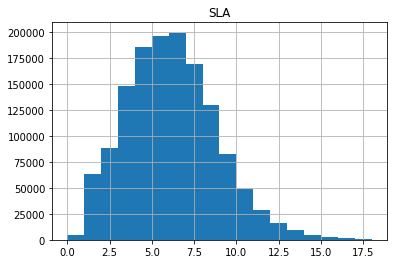

In [23]:
# Histogram to understand huge demand time slots
ecom.hist(column='SLA',bins=18)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B10310DDD8>]],
      dtype=object)

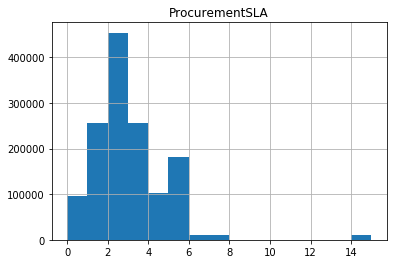

In [24]:
# Histogram to understand huge demand time slots
ecom.hist(column='ProcurementSLA',bins=15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B10C4A2C18>]],
      dtype=object)

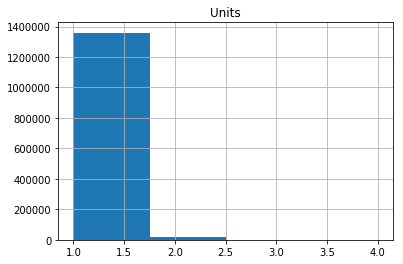

In [25]:
## Histogram to understand huge demand time slots
ecom.hist(column='Units',bins=4)

In [26]:
ecom['PP'] = ecom['MRP'].apply(lambda x:'Display_Price_ending_with_99' if str(x).endswith('99') else 'Display_Price_others')

In [27]:
price_df = pd.get_dummies(ecom['PP'])
price_df.head()

,Display_Price_ending_with_99,Display_Price_others
0,0,1
1,0,1
2,1,0
3,1,0
4,1,0


In [28]:
ecom = pd.concat([ecom,price_df],axis=1)
ecom.head()

,FSNID,OrderDate,Year,Month,OrderId,OrderItemId,GMV,Units,DeliveryBDay,DeliveryCDays,...,ProductSuperCategory,ProductCategory,ProductSubCategory,ProductVertical,MRP,ProcurementSLA,Week,PP,Display_Price_ending_with_99,Display_Price_others
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3419300926147000.0,3419300926147000.0,6400.0,1,0.0,0.0,...,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,42,Display_Price_others,0,1
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1420830839915200.0,1420830839915200.0,6900.0,1,0.0,0.0,...,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,43,Display_Price_others,0,1
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2421912925714800.0,2421912925714800.0,1990.0,1,0.0,0.0,...,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,43,Display_Price_ending_with_99,1,0
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4416592101738400.0,4416592101738400.0,1690.0,1,0.0,0.0,...,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,42,Display_Price_ending_with_99,1,0
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4419525153426400.0,4419525153426400.0,1618.0,1,0.0,0.0,...,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,42,Display_Price_ending_with_99,1,0


In [29]:
ecom.drop(['PP'],axis=1,inplace=True)
ecom.columns

Index(['FSNID', 'OrderDate', 'Year', 'Month', 'OrderId', 'OrderItemId', 'GMV',
       'Units', 'DeliveryBDay', 'DeliveryCDays', 'OrderPaymentType', 'SLA',
       'CustomerId', 'Pincode', 'ProductSuperCategory', 'ProductCategory',
       'ProductSubCategory', 'ProductVertical', 'MRP', 'ProcurementSLA',
       'Week', 'Display_Price_ending_with_99', 'Display_Price_others'],
      dtype='object')

In [30]:
#filtering the data for the required 3 categories
ecom=ecom[(ecom['ProductSubCategory']=='CameraAccessory')| (ecom['ProductSubCategory']=='HomeAudio')|(ecom['ProductSubCategory']=='GamingAccessory')]

### EDA On the data

- By Payment Type 
- By Category,SubCategory
- By Sales Units
- By GMV, etc

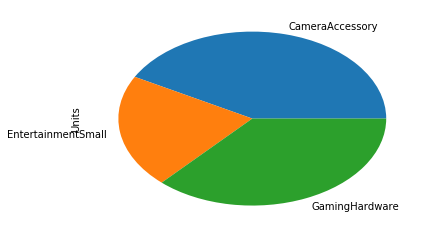

In [31]:
# Category for Units Sold
ecom.groupby('ProductCategory')['Units'].sum().plot(kind='pie')

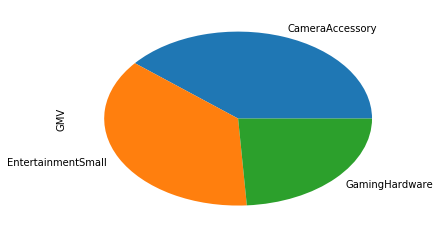

In [32]:
ecom.groupby('ProductCategory')['GMV'].sum().plot(kind='pie')

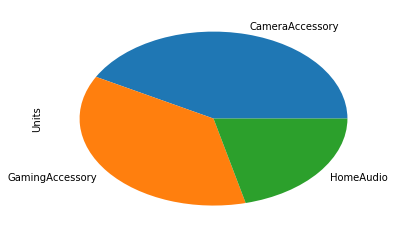

In [33]:
# SubCategory for Units Sold
ecom.groupby('ProductSubCategory')['Units'].sum().plot(kind='pie')
# Speaker and camera Acessoryies are fast moving items

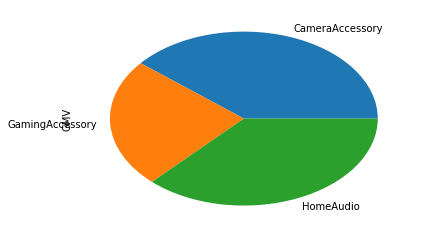

In [34]:
ecom.groupby('ProductSubCategory')['GMV'].sum().plot(kind='pie')
# Speaker and camera Acessoryies are fast moving items

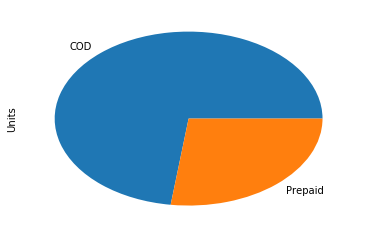

In [35]:
# Payment type for Units Sold
ecom.groupby('OrderPaymentType')['Units'].sum().plot(kind='pie')
# People trend to buy with COD payment type

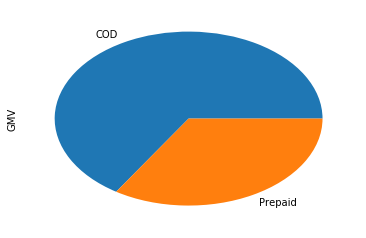

In [36]:
ecom.groupby('OrderPaymentType')['GMV'].sum().plot(kind='pie')
# People trend to buy with COD payment type

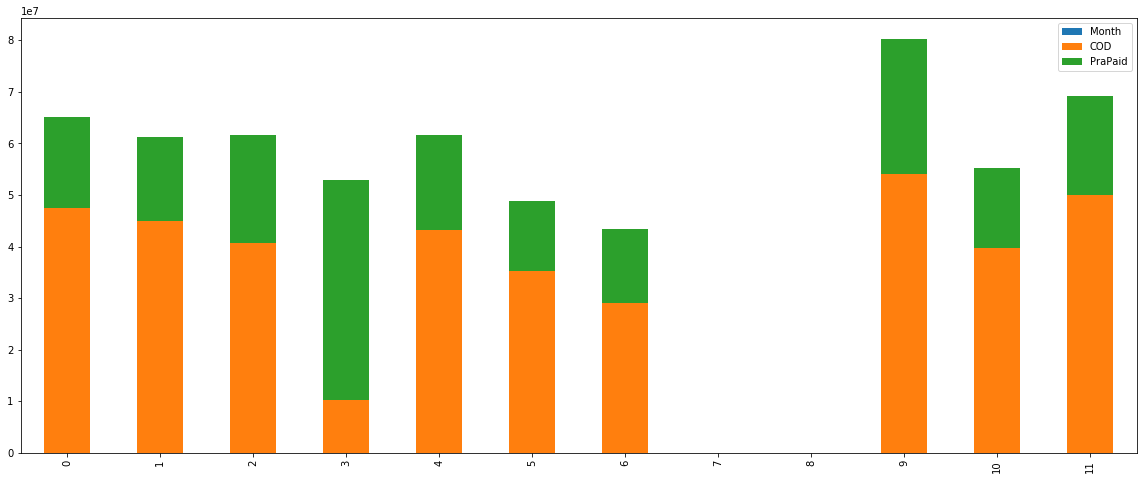

In [37]:
#Month vs PaymentType
MonthPayment = pd.pivot_table(ecom, index=['Month'],columns=['OrderPaymentType'],values=['GMV'],aggfunc=np.sum).reset_index()
MonthPayment.columns = MonthPayment.columns.droplevel(1)
MonthPayment.columns = ['Month', 'COD', 'PraPaid']    
MonthPayment.plot(kind="bar", stacked=True,figsize=(20,8))

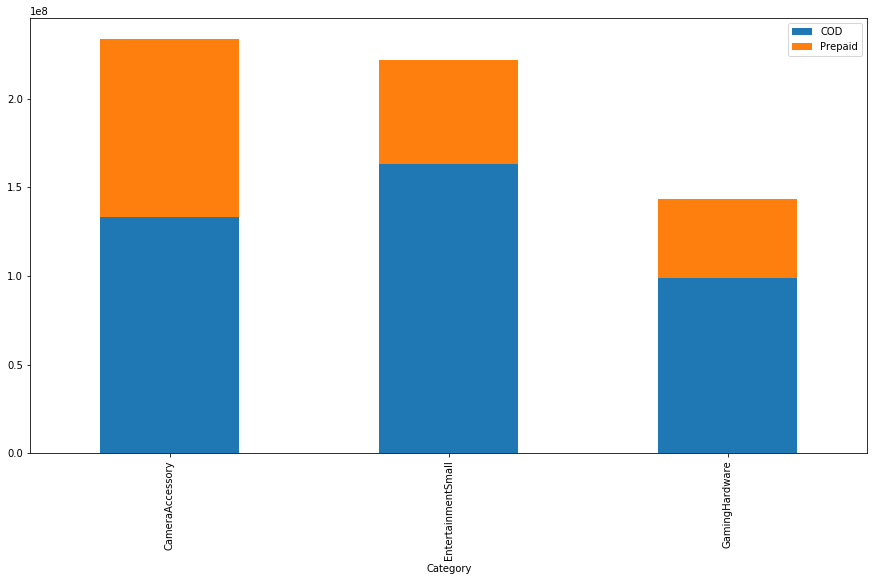

In [38]:
#Category vs PaymentType
Cat_Payment = pd.pivot_table(ecom, index=['ProductCategory'],columns=['OrderPaymentType'],values=['GMV'],aggfunc=np.sum).reset_index()
Cat_Payment.columns = Cat_Payment.columns.droplevel(1)
Cat_Payment.columns = ['Category','COD','Prepaid'] 
Cat_Payment.set_index('Category',inplace=True)
Cat_Payment.plot(kind="bar", stacked=True,figsize=(15,8))

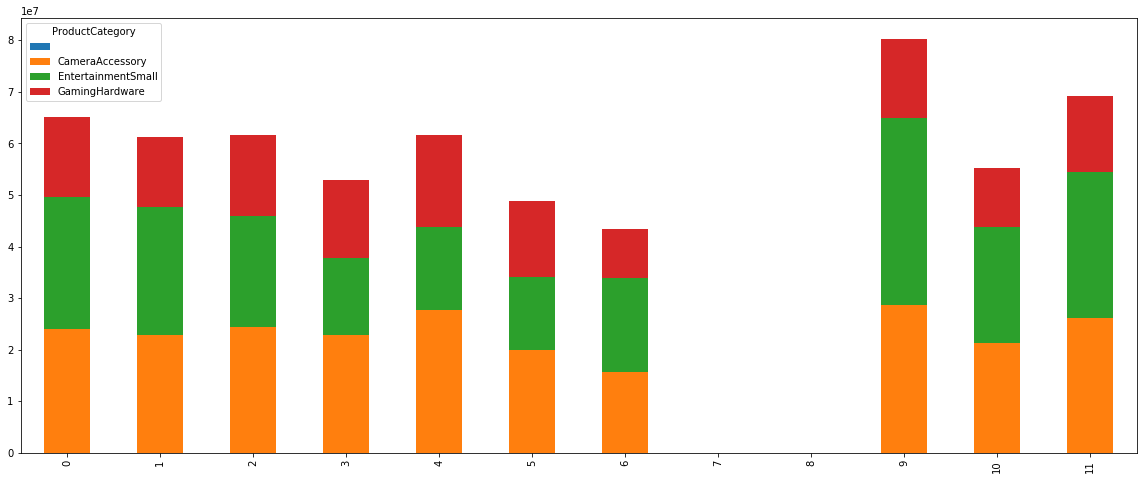

In [39]:
#Month vs Category
Month_Cat = pd.pivot_table(ecom, index=['Month'],columns=['ProductCategory'],values=['GMV'],aggfunc=np.sum).reset_index()
Month_Cat.columns = Month_Cat.columns.droplevel(0) 
Month_Cat.plot(kind="bar", stacked=True,figsize=(20,8))

In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
# recaling the variables: MRP,GMV

# filter only MRP, Price
df = ecom.loc[:,['MRP', 'GMV']]
df_columns = df.columns

scaler = MinMaxScaler()
df = scaler.fit_transform(df)
# rename columns (since now its an np array)
df = pd.DataFrame(df)
df.columns = df_columns

df.head()

,MRP,GMV
0,0.039416,0.043222
1,0.039416,0.046599
2,0.011117,0.013435
3,0.011117,0.011408
4,0.011117,0.010922


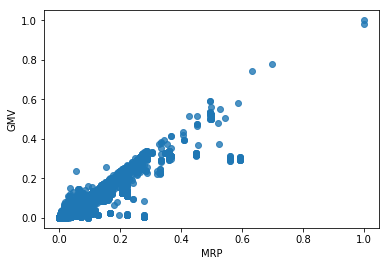

In [41]:
sns.regplot(x="MRP", y="GMV", data=df, fit_reg=False)

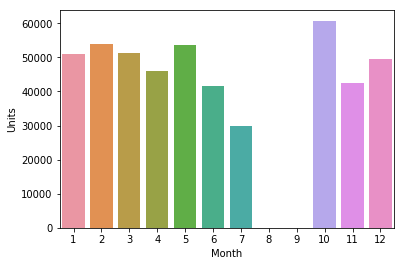

In [42]:
Month_GMV = pd.pivot_table(ecom, index=['Month'],values=['Units','GMV'],aggfunc=np.sum).reset_index()
sns.barplot(x=Month_GMV.Month, y=Month_GMV.Units)

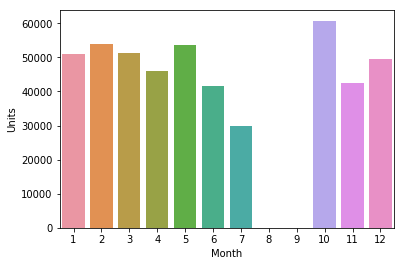

In [43]:
sns.barplot(x=Month_GMV.Month, y=Month_GMV.Units)

In [44]:
# Importing Canada Holidays list for 2015 and 2016
Holidays = holidays.Canada(years=[2015,2016], state="ON")
Holidays=pd.DataFrame(Holidays,index=[0]).transpose() 
Holidays.reset_index(level=0, inplace=True)
Holidays['Holidays']= pd.to_datetime(Holidays['index'])
Holidays.drop([Holidays.columns[1]], axis=1, inplace=True)
Holidays.drop([Holidays.columns[0]], axis=1, inplace=True)

In [45]:
Dt = ecom.loc[:,['OrderDate','Week']]
Dt.head()

,OrderDate,Week
0,2015-10-17 15:11:54,42
1,2015-10-19 10:07:22,43
2,2015-10-20 15:45:56,43
3,2015-10-14 12:05:15,42
4,2015-10-17 21:25:03,42


In [46]:
Dt['Date'] = Dt['OrderDate'].dt.normalize()
Dt['Month'] = Dt['Date'].dt.month
Dt['Year'] = Dt['Date'].dt.year
Dt['Day'] = Dt['Date'].dt.weekday_name
Dt.head()

,OrderDate,Week,Date,Month,Year,Day
0,2015-10-17 15:11:54,42,2015-10-17,10,2015,Saturday
1,2015-10-19 10:07:22,43,2015-10-19,10,2015,Monday
2,2015-10-20 15:45:56,43,2015-10-20,10,2015,Tuesday
3,2015-10-14 12:05:15,42,2015-10-14,10,2015,Wednesday
4,2015-10-17 21:25:03,42,2015-10-17,10,2015,Saturday


In [47]:
# Creating array with Special Sale days
SaleDays = pd.to_datetime(['2015-07-18','2015-07-19','2015-08-15','2015-08-16','2015-08-17','2015-08-28','2015-08-29','2015-08-30','2015-10-15','2015-10-16','2015-10-17','2015-11-07','2015-11-08','2015-11-09','2015-11-10','2015-11-11','2015-11-12','2015-11-13','2015-11-14','2015-12-25','2015-12-26','2015-12-27','2015-12-28','2015-12-29','2015-12-30','2015-12-31','2016-01-01','2016-01-02','2016-01-03','2016-01-20','2016-01-21','2016-01-22','2016-02-01','2016-02-02','2016-02-20','2016-02-21','2016-02-14','2016-02-15','2016-03-07','2016-03-08','2016-03-09','2016-03-25','2016-03-26','2016-03-27'])

# Adding SaleDay,Holiday,WeekEnd,Pay Days flag to Date DataFrame
Dt['SaleFlag'] = Dt.apply(lambda x:1 if x.Date in (SaleDays) else 0, axis=1)
Dt['WeekendFlag'] = Dt.apply(lambda x:1 if x.Day in ('Saturday','Sunday') else 0, axis=1)
Dt['PayDayFlag'] = Dt.apply(lambda x:1 if x.Date.day==1 else 0, axis=1)
Dt['HoliDayFlag'] = Dt.apply(lambda x:1 if x.Date in (Holidays.Holidays.tolist()) else 0, axis=1)

Dt.head()

,OrderDate,Week,Date,Month,Year,Day,SaleFlag,WeekendFlag,PayDayFlag,HoliDayFlag
0,2015-10-17 15:11:54,42,2015-10-17,10,2015,Saturday,1,1,0,0
1,2015-10-19 10:07:22,43,2015-10-19,10,2015,Monday,0,0,0,0
2,2015-10-20 15:45:56,43,2015-10-20,10,2015,Tuesday,0,0,0,0
3,2015-10-14 12:05:15,42,2015-10-14,10,2015,Wednesday,0,0,0,0
4,2015-10-17 21:25:03,42,2015-10-17,10,2015,Saturday,1,1,0,0


#### Let's divide the dataset into 3 dataframes based on category.

In [48]:
GamingAccessory=ecom[(ecom['ProductSubCategory']=='GamingAccessory')]
HomeAudio=ecom[(ecom['ProductSubCategory']=='HomeAudio')]
CameraAccessory=ecom[(ecom['ProductSubCategory']=='CameraAccessory')]

In [49]:
print(GamingAccessory.shape)
print(HomeAudio.shape)
print(CameraAccessory.shape)

(171939, 23)
(100596, 23)
(197529, 23)


In [50]:
# Importing Media Investiment and NPS information
ExcelBook = pd.ExcelFile("Media data and other information.xlsx")

# Reading Media Investment and NPS WorkSheet and creating dataset
Media_spend = ExcelBook.parse("Media Investment")
NPS = ExcelBook.parse("Monthly NPS Score")

In [51]:
# Dropping columns which doesnt have data
Media_spend = Media_spend.drop(['Unnamed: 0'], axis=1)

# Getting column headers 
Header = Media_spend.iloc[0]
Media_spend = Media_spend[1:] 
Media_spend.columns = Header
Media_spend.head()

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
1,2015,7,17.0618,0.21533,2.53301,7.41427,0.000932898,1.32728,0.547254,5.0237,NaN,NaN
2,2015,8,5.06431,0.00643807,1.27807,1.06333,6.32513e-06,0.129244,0.073684,2.51353,NaN,NaN
3,2015,9,96.2544,3.8795,1.35653,62.7877,0.610292,16.38,5.03827,6.20215,NaN,NaN
4,2015,10,170.156,6.14471,12.6225,84.6725,3.44407,24.3718,6.97371,31.927,NaN,NaN
5,2015,11,51.2162,4.22063,1.27547,14.1721,0.168633,19.5616,6.59577,5.22203,NaN,NaN


In [52]:
Media_spend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 1 to 16
Data columns (total 12 columns):
Year                 12 non-null object
Month                12 non-null object
Total Investment     12 non-null object
TV                   13 non-null object
Digital              12 non-null object
Sponsorship          12 non-null object
Content Marketing    12 non-null object
Online marketing     12 non-null object
 Affiliates          12 non-null object
SEM                  12 non-null object
Radio                3 non-null object
Other                3 non-null object
dtypes: object(12)
memory usage: 1.6+ KB


In [53]:
Media_spend['Year'] = pd.to_numeric(Media_spend['Year'], errors='coerce')
Media_spend['Month'] = pd.to_numeric(Media_spend['Month'], errors='coerce')
Media_spend = Media_spend.dropna(subset=['Year','Month'])

In [54]:
# Converting datatypes from string to float
Media_spend['Total Investment']= Media_spend['Total Investment'].astype(float)
Media_spend['TV']= Media_spend['TV'].astype(float)
Media_spend['Digital']= Media_spend['Digital'].astype(float)
Media_spend['Sponsorship']= Media_spend['Sponsorship'].astype(float)
Media_spend['Content Marketing']= Media_spend['Content Marketing'].astype(float)
Media_spend['Online marketing']= Media_spend['Online marketing'].astype(float)
Media_spend[' Affiliates']= Media_spend[' Affiliates'].astype(float)
Media_spend['SEM']= Media_spend['SEM'].astype(float)
Media_spend['Radio']= Media_spend['Radio'].astype(float)
Media_spend['Other']= Media_spend['Other'].astype(float)
Media_spend['Year']= Media_spend['Year'].astype(int)
Media_spend['Month']= Media_spend['Month'].astype(int)

#Removing Space from Affiliates
Media_spend=Media_spend.rename({" Affiliates": "Affiliates"},axis=1) 

In [55]:
Media_spend.head()

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
1,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,NaN,NaN
2,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,NaN,NaN
3,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,NaN,NaN
4,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,NaN,NaN
5,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,NaN,NaN


In [56]:
# Adding days in a month to get day investment

# Summarising month days in a month
Month_days = Dt.groupby(['Month'],as_index=False)
Month_days=Month_days.count()
Month_days=Month_days.rename({"Date": "DaysinMonth"},axis=1)
Month_days = Month_days.drop(['Year','Week','Day','SaleFlag','WeekendFlag','PayDayFlag','HoliDayFlag'], axis=1)

Media_spend=pd.merge(Media_spend, Month_days, on=['Month'], how='outer')

# Deriving media spend per day
Media_spend['Total Investment']=(Media_spend['Total Investment'] / Media_spend['DaysinMonth'])
Media_spend['TV']=(Media_spend['TV'] /Media_spend['DaysinMonth'])
Media_spend['Digital']=(Media_spend['Digital'] /Media_spend['DaysinMonth'])
Media_spend['Sponsorship']=(Media_spend['Sponsorship'] /Media_spend['DaysinMonth'])
Media_spend['Content Marketing']=(Media_spend['Content Marketing'] /Media_spend['DaysinMonth'])
Media_spend['Online marketing']=(Media_spend['Online marketing'] /Media_spend['DaysinMonth'])
Media_spend['Affiliates']=(Media_spend['Affiliates'] /Media_spend['DaysinMonth'])
Media_spend['SEM']=(Media_spend['SEM'] /Media_spend['DaysinMonth'])
Media_spend['Radio']=(Media_spend['Radio'] /Media_spend['DaysinMonth'])
Media_spend['Other']=(Media_spend['Other'] /Media_spend['DaysinMonth'])


In [57]:
NPS.transpose=pd.DataFrame(NPS.T)
NPS.transpose
df_NPS=NPS.transpose.rename(columns=NPS.transpose.iloc[0]).drop(NPS.transpose.index[0])

In [58]:
df_monthly_nps=pd.DataFrame({'index':[1,2,3,4,5,6,7,8,9,10,11,12],
                            'Year' : [2015,2015,2015,2015,2015,2015,2016,2016,2016,2016,2016,2016],
                            'Month' :[7,8,9,10,11,12,1,2,3,4,5,6]})
df_monthly_nps

,index,Year,Month
0,1,2015,7
1,2,2015,8
2,3,2015,9
3,4,2015,10
4,5,2015,11
5,6,2015,12
6,7,2016,1
7,8,2016,2
8,9,2016,3
9,10,2016,4


In [59]:
colls=['NPS', 'Stock Index', 'index']
df_NPS.reset_index()
df_NPS['index']=range(1,13)
df_NPS[colls]=df_NPS[colls].apply(pd.to_numeric)
df_NPS.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, July'15 to June'16
Data columns (total 3 columns):
NPS            12 non-null float64
Stock Index    12 non-null float64
index          12 non-null int32
dtypes: float64(2), int32(1)
memory usage: 336.0+ bytes


In [60]:
df_monthlynps=pd.merge(df_monthly_nps,df_NPS,how='inner', on='index')

In [61]:
df_monthlynps

,index,Year,Month,NPS,Stock Index
0,1,2015,7,54.599588,1177.0
1,2,2015,8,59.987101,1206.0
2,3,2015,9,46.925419,1101.0
3,4,2015,10,44.398389,1210.0
4,5,2015,11,47.000000,1233.0
5,6,2015,12,45.800000,1038.0
6,7,2016,1,47.093031,1052.0
7,8,2016,2,50.327406,1222.0
8,9,2016,3,49.020550,1015.0
9,10,2016,4,51.827605,1242.0


In [62]:
Dt=pd.merge(Dt, Media_spend, on=['Year','Month'], how='outer')

In [63]:
Dt=pd.merge(Dt, df_monthlynps, on=['Year','Month'], how='outer')

In [64]:
# Summarising Media Spend , Holidays,Special Sale Days,PayDays at one level
WeekSpend = pd.pivot_table(Dt, index=['Week'],values=['Total Investment','TV','Digital','Sponsorship','Content Marketing','Online marketing','Affiliates','SEM','Radio','Other',
'SaleFlag','WeekendFlag','PayDayFlag','HoliDayFlag'],aggfunc=[np.sum]).reset_index()
WeekSpend.columns = ['Week','Affiliates','ContentMarketing','Digital','HoliDays','OnlineMarketing','Other','PayDays','Radio','SEM','SaleDays','Sponsorship','TV','TotalInvestment','WkEnds']   


In [65]:
WeekSpendPT2 = pd.pivot_table(Dt, index=['Week'],values=['NPS'],aggfunc=[np.mean]).reset_index()
WeekSpendPT2.columns = ['Week','NPS']

In [66]:
WeekSpend=pd.merge(WeekSpend, WeekSpendPT2, on=['Week'], how='outer')
WeekSpend.head(5)

,Week,Affiliates,ContentMarketing,Digital,HoliDays,OnlineMarketing,Other,PayDays,Radio,SEM,SaleDays,Sponsorship,TV,TotalInvestment,WkEnds,NPS
0,27,0.001714,0.000003,0.007933,6,0.004157,0.0,6,0.0,0.015734,0,0.023221,0.000674,0.053435,16,54.599588
1,28,0.147832,0.000252,0.684252,0,0.358542,0.0,0,0.0,1.357069,0,2.002843,0.058168,4.608958,2275,54.599588
2,29,0.153708,0.000262,0.711451,0,0.372794,0.0,0,0.0,1.411013,2253,2.082456,0.060480,4.792165,2253,54.599588
3,30,0.143952,0.000245,0.666293,0,0.349132,0.0,0,0.0,1.321452,0,1.950278,0.056641,4.487994,2177,54.599588
4,31,0.113318,0.000171,0.700195,0,0.265561,0.0,1,0.0,1.384702,0,1.547447,0.040359,4.051752,3,54.602646


In [67]:
print(ecom.shape) # checking Dataset size
print(ecom['ProductSubCategory'].unique()) # subcategory values

(470064, 23)
['CameraAccessory' 'GamingAccessory' 'HomeAudio']


In [68]:
ecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 470064 entries, 0 to 1437935
Data columns (total 23 columns):
FSNID                           470064 non-null object
OrderDate                       470064 non-null datetime64[ns]
Year                            470064 non-null int64
Month                           470064 non-null int64
OrderId                         470064 non-null object
OrderItemId                     470064 non-null object
GMV                             470064 non-null float64
Units                           470064 non-null int64
DeliveryBDay                    470064 non-null float64
DeliveryCDays                   470064 non-null float64
OrderPaymentType                470064 non-null object
SLA                             470064 non-null int64
CustomerId                      470064 non-null float64
Pincode                         470064 non-null float64
ProductSuperCategory            470064 non-null object
ProductCategory                 470064 non-null object

### Creating KPIs
1. KPI - List price for all the products
2. KPI - Promotional Offer for all the products
3. Clustering- Creating a new KPI.It divides the products into three categories based on MRP and num units sold - mass market, medium market and premium product
4. Payment model indicator

In [69]:
### KPI ###
# Identifying Listing Price
ecom["ListingPrice"]=(ecom["GMV"]/ecom["Units"])

# KPI for Promotional Offers
ecom["PromoOffer"]=(ecom["MRP"]-ecom["ListingPrice"])/ecom["GMV"]

ecom["Delivery_time"] =ecom["SLA"] - (ecom["DeliveryBDay"]+ecom["DeliveryCDays"]+ecom["ProcurementSLA"])
ecom["Delivery_status"] = ecom["Delivery_time"].apply(lambda x: 'Arriving_Early' if x<0 else('On_Time' if x==0  else 'Delayed'))
delivery_stat = pd.get_dummies(ecom["Delivery_status"])
ecom = pd.concat([ecom, delivery_stat], axis = 1)
ecom.drop(['Delivery_status'], axis = 1, inplace = True)


# KPI for deriving Onlinepayment i.e PrePaid Rate
ecom['PaymentType_alt'] = ecom.apply(lambda x:'COD' if x.OrderPaymentType=='COD' else 'Others', axis=1)
ecom['OrderPaymentType'] = ecom.apply(lambda x:0 if x.OrderPaymentType=='COD' else 1, axis=1)
payment_type = pd.get_dummies(ecom['PaymentType_alt'])
ecom = pd.concat([ecom, payment_type],axis=1)
Prepaid_Orders = pd.pivot_table(ecom, index=['ProductSubCategory','Week'],values=['OrderPaymentType'],aggfunc=[len,np.sum]).reset_index().rename(columns={'len': 'TotalOrders','sum': 'OnlineOrders'})
Prepaid_Orders.columns = Prepaid_Orders.columns.droplevel(1)
ecom.drop(['PaymentType_alt'], axis = 1, inplace = True)

Prepaid_Orders["OnlinePayRate"]=100*(Prepaid_Orders["OnlineOrders"]/Prepaid_Orders["TotalOrders"])
Prepaid_Orders = Prepaid_Orders.drop(['TotalOrders','OnlineOrders'], axis=1)
Prepaid_Orders.columns = ['ProductSubCategory','Week','OnlinePayRate'] 
Prepaid_Orders.head(5)

# KPI  for Price Tag by Vertical using Units MRP andListing Price with help of ClusterAnalysis
Cluster = pd.pivot_table(ecom, index=['ProductVertical'],values=['Units','MRP','ListingPrice'],aggfunc=np.sum).reset_index()

In [70]:
# understanding Product based on Price units sold using KMeans Cluster
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters = 3)
Y_Pred=kmean.fit_predict(Cluster[['Units','MRP','ListingPrice']])
Cluster['Cluster'] = Y_Pred
Cluster.head(5)

,ProductVertical,ListingPrice,MRP,Units,Cluster
0,Binoculars,2.335195e+07,38618316,12122,0
1,BoomBox,6.526150e+06,7955342,1987,0
2,CameraAccessory,1.147502e+06,1908840,1590,0
3,CameraBag,2.072171e+07,32342135,14754,0
4,CameraBattery,1.931267e+07,43933647,32371,0


In [71]:
Cluster['PriceTag'] = Cluster.apply(lambda x:'Mass' if x.Cluster==2 else 'Premium' if x.Cluster==0 else 'Aspiring', axis=1)
Cluster_new = Cluster.drop(['Units','MRP','ListingPrice','Cluster'], axis=1)

In [72]:
# Joining Price Tag to Transaction data at Vertical Level
ecom=pd.merge(ecom, Cluster_new, on=['ProductVertical'], how='outer')

In [73]:
# Joining Prepaid rate to Transaction data at Subcategory & Week Level
ecom=pd.merge(ecom, Prepaid_Orders, on=['ProductSubCategory','Week'], how='outer')

In [74]:
vertical = pd.get_dummies(ecom['ProductVertical'])
ecom = pd.concat([ecom, vertical], axis = 1)

In [75]:
ecom.columns

Index(['FSNID', 'OrderDate', 'Year', 'Month', 'OrderId', 'OrderItemId', 'GMV',
       'Units', 'DeliveryBDay', 'DeliveryCDays', 'OrderPaymentType', 'SLA',
       'CustomerId', 'Pincode', 'ProductSuperCategory', 'ProductCategory',
       'ProductSubCategory', 'ProductVertical', 'MRP', 'ProcurementSLA',
       'Week', 'Display_Price_ending_with_99', 'Display_Price_others',
       'ListingPrice', 'PromoOffer', 'Delivery_time', 'Arriving_Early',
       'Delayed', 'On_Time', 'COD', 'Others', 'PriceTag', 'OnlinePayRate',
       'Binoculars', 'BoomBox', 'CameraAccessory', 'CameraBag',
       'CameraBattery', 'CameraBatteryCharger', 'CameraBatteryGrip',
       'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone',
       'CameraMount', 'CameraRemoteControl', 'CameraTripod', 'CoolingPad',
       'DJController', 'Dock', 'DockingStation', 'ExtensionTube', 'FMRadio',
       'Filter', 'Flash', 'FlashShoeAdapter', 'GameControlMount', 'GamePad',
       'GamingAccessoryKit', 'GamingAd

In [76]:
# Generating Weeklevel aggeration data from transaction data for modeling
TransSC = pd.pivot_table(ecom, index=['ProductSubCategory','Week'],values=['GMV','Units','PromoOffer','Arriving_Early', 
'Delayed' , 'On_Time','Display_Price_ending_with_99','Display_Price_others','COD', 'Others', 'Binoculars', 'BoomBox',
'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
'CameraTripod', 'CoolingPad', 'DJController', 'Dock', 'DockingStation',
'ExtensionTube', 'FMRadio', 'Filter', 'Flash', 'FlashShoeAdapter',
'GameControlMount', 'GamePad', 'GamingAccessoryKit', 'GamingAdapter',
'GamingChargingStation', 'GamingHeadset', 'GamingKeyboard',
'GamingMemoryCard', 'GamingMouse', 'GamingMousePad', 'GamingSpeaker',
'HiFiSystem', 'HomeAudioSpeaker', 'JoystickGamingWheel',
'KaraokePlayer', 'Lens', 'MotionController', 'ReflectorUmbrella',
'SlingBox', 'Softbox', 'SoundMixer', 'Strap', 'TVOutCableAccessory',
'Teleconverter', 'Telescope', 'VoiceRecorder'],aggfunc=[np.sum]).reset_index()


In [77]:
TransSC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 61 columns):
(ProductSubCategory, )                 144 non-null object
(Week, )                               144 non-null int64
(sum, Arriving_Early)                  144 non-null float64
(sum, Binoculars)                      144 non-null float64
(sum, BoomBox)                         144 non-null uint8
(sum, COD)                             144 non-null float64
(sum, CameraAccessory)                 144 non-null uint8
(sum, CameraBag)                       144 non-null float64
(sum, CameraBattery)                   144 non-null float64
(sum, CameraBatteryCharger)            144 non-null float64
(sum, CameraBatteryGrip)               144 non-null uint8
(sum, CameraEyeCup)                    144 non-null uint8
(sum, CameraFilmRolls)                 144 non-null uint8
(sum, CameraHousing)                   144 non-null uint8
(sum, CameraMicrophone)                144 non-null uint8
(sum, Camera

In [78]:
TransSC.columns = ['ProductSubCategory','Week','Arriving_Early','Binoculars', 'BoomBox','COD','CameraAccessory', 
                   'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'CameraTripod', 'CoolingPad', 'DJController','Delayed',
        'Display_Price_ending_with_99','Display_Price_others','Dock', 'DockingStation',
       'ExtensionTube', 'FMRadio', 'Filter', 'Flash', 'FlashShoeAdapter','GMV',
        'GameControlMount', 'GamePad', 'GamingAccessoryKit', 'GamingAdapter',
       'GamingChargingStation', 'GamingHeadset', 'GamingKeyboard',
       'GamingMemoryCard', 'GamingMouse', 'GamingMousePad', 'GamingSpeaker',
       'HiFiSystem', 'HomeAudioSpeaker', 'JoystickGamingWheel',
       'KaraokePlayer', 'Lens', 'MotionController',
       'On_Time','Others','PromoOffer','ReflectorUmbrella',
       'SlingBox', 'Softbox', 'SoundMixer', 'Strap', 'TVOutCableAccessory',
       'Teleconverter', 'Telescope',
        'Units', 'VoiceRecorder'] 

In [79]:
# Sped is in Crs since GMV needs to be converted to Crs
TransSC['GMV']=TransSC['GMV']/10000000

In [80]:
#Weeklevel aggeration data from transaction data for modeling more varibles
Agg = pd.pivot_table(ecom, index=['ProductSubCategory','Week'],values=['MRP','ProcurementSLA','SLA','DeliveryBDay','DeliveryCDays'],aggfunc=[np.mean]).reset_index()
Agg.columns = ['ProductSubCategory','Week','DeliveryBDays','DeliveryCDays','SLA','MRP','ProcurementSLA'] 
Agg.head(5)

,ProductSubCategory,Week,DeliveryBDays,DeliveryCDays,SLA,MRP,ProcurementSLA
0,CameraAccessory,27,0.807692,0.846154,1511.961538,2.846154,2.384615
1,CameraAccessory,28,0.000000,0.000000,2492.739756,2.757009,7.035586
2,CameraAccessory,29,0.000000,0.000000,2578.240574,2.788455,6.385385
3,CameraAccessory,30,0.000000,0.000000,2565.440541,2.842905,6.405743
4,CameraAccessory,31,0.000000,0.000000,2513.944982,2.795211,6.373408


In [81]:
# Joining Transactional Week aggregation data
TransSC=pd.merge(TransSC, Agg, on=['ProductSubCategory','Week'], how='outer')

In [82]:
# Joining PrepaidRate to transactional Week aggregation data
TransSC=pd.merge(TransSC, Prepaid_Orders, on=['ProductSubCategory','Week'], how='outer')


In [83]:
# Joining Weekly Spend to transactional Week aggregation data
# WeekEnds is constant for a week hence may not be useful hence dropping
WeekSpend = WeekSpend.drop(['WkEnds'], axis=1)
TransSC=pd.merge(TransSC, WeekSpend, on=['Week'], how='outer')
TransSC.head(5)

,ProductSubCategory,Week,Arriving_Early,Binoculars,BoomBox,COD,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,...,OnlineMarketing,Other,PayDays,Radio,SEM,SaleDays,Sponsorship,TV,TotalInvestment,NPS
0,CameraAccessory,27,20.0,1.0,0,0.0,1,2.0,4.0,1.0,...,0.004157,0.0,6,0.0,0.015734,0,0.023221,0.000674,0.053435,54.599588
1,GamingAccessory,27,19.0,0.0,0,0.0,0,0.0,0.0,0.0,...,0.004157,0.0,6,0.0,0.015734,0,0.023221,0.000674,0.053435,54.599588
2,HomeAudio,27,26.0,0.0,5,1.0,0,0.0,0.0,0.0,...,0.004157,0.0,6,0.0,0.015734,0,0.023221,0.000674,0.053435,54.599588
3,CameraAccessory,28,287.0,203.0,0,1869.0,42,331.0,642.0,220.0,...,0.358542,0.0,0,0.0,1.357069,0,2.002843,0.058168,4.608958,54.599588
4,GamingAccessory,28,864.0,0.0,0,2203.0,0,0.0,0.0,0.0,...,0.358542,0.0,0,0.0,1.357069,0,2.002843,0.058168,4.608958,54.599588


# # Gaming Accessories 

- EDA ,Correlation,Linear Model Building with feature Engineering

In [84]:
# Generating Camera Accessories Transactional Data
Gaming=ecom.drop(ecom[(ecom.ProductSubCategory != 'GamingAccessory')].index)

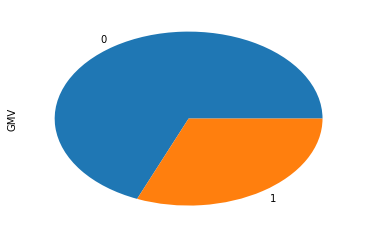

In [85]:
# Pie chart for COD and Prepaid Orders
Gaming.groupby('OrderPaymentType')['GMV'].sum().plot(kind='pie')

In [86]:
ecom['OrderPaymentType'].nunique()

2

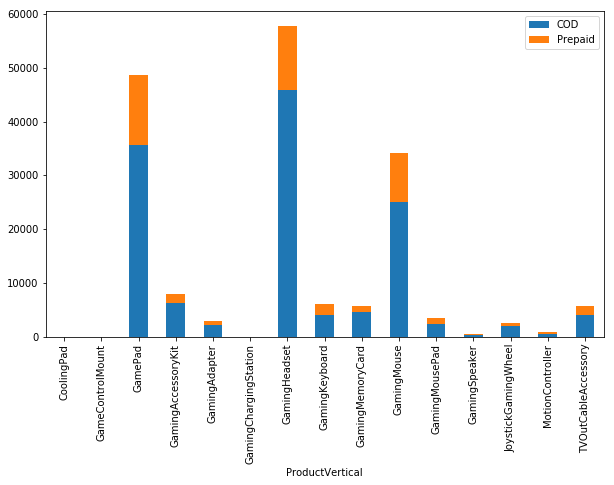

In [87]:
# Payment Type by Vertical sales view by units
CA = pd.pivot_table(Gaming, index=['ProductVertical'],columns=['OrderPaymentType'],values=['Units'],aggfunc=np.sum).reset_index()
CA.columns = CA.columns.droplevel(1)
CA.columns = ['ProductVertical','COD','Prepaid'] 
CA.set_index('ProductVertical',inplace=True)
CA.plot(kind="bar", stacked=True,figsize=(10,6))

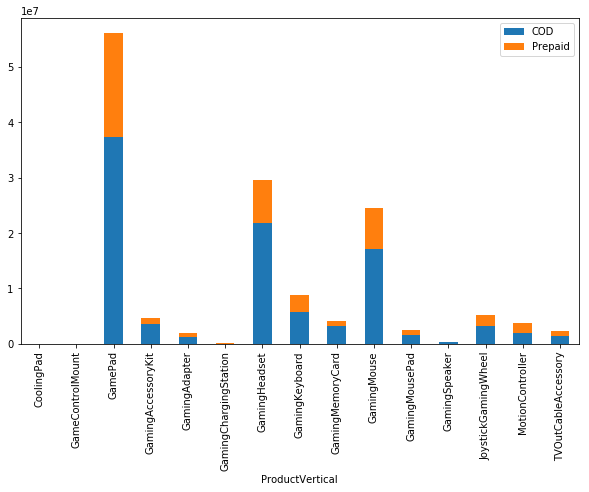

In [89]:
# Payment Type by Vertical sales view by GMV
CA = pd.pivot_table(Gaming, index=['ProductVertical'],columns=['OrderPaymentType'],values=['GMV'],aggfunc=np.sum).reset_index()
CA.columns = CA.columns.droplevel(1)
CA.columns = ['ProductVertical','COD','Prepaid'] 
CA.set_index('ProductVertical',inplace=True)
CA.plot(kind="bar", stacked=True,figsize=(10,6))

In [90]:
## output generation for Tablue
TransSC.to_csv("TransSC.csv", sep='\t', encoding='utf-8')

In [91]:
# Generating Data Frames for each Surver category week level aggregation data
WL_camera=TransSC.drop(TransSC[(TransSC.ProductSubCategory != 'CameraAccessory')].index)
print(WL_camera.shape)
WL_Game=TransSC.drop(TransSC[(TransSC.ProductSubCategory != 'GamingAccessory')].index)
print(WL_Game.shape)
WL_Homeaudio=TransSC.drop(TransSC[(TransSC.ProductSubCategory != 'HomeAudio')].index)
print(WL_Homeaudio.shape)

(48, 81)
(50, 81)
(46, 81)


In [92]:
CA_col = Gaming['ProductVertical'].unique()
print(sorted(CA_col))
#for items in df_CA_RD

['CoolingPad', 'GameControlMount', 'GamePad', 'GamingAccessoryKit', 'GamingAdapter', 'GamingChargingStation', 'GamingHeadset', 'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse', 'GamingMousePad', 'GamingSpeaker', 'JoystickGamingWheel', 'MotionController', 'TVOutCableAccessory']


In [93]:
df_CA1 = WL_Game.copy()
for items in WL_Game.columns:
    if items not in CA_col and items in vertical.columns:
        del WL_Game[items]

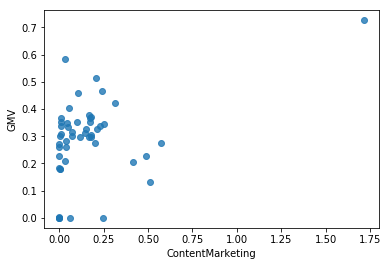

In [94]:
# Scater plot for GMV Generated by Sped type ContentMarketing
sns.regplot(x="ContentMarketing", y="GMV", data=WL_Game[['ContentMarketing','GMV']], fit_reg=False)

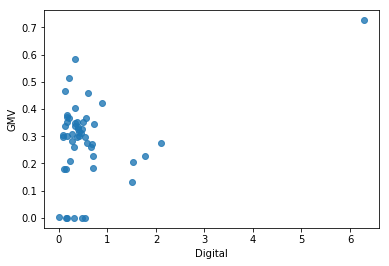

In [95]:
# Scater plot for GMV Generated by Sped type Digital
sns.regplot(x="Digital", y="GMV", data=WL_Game[['Digital','GMV']], fit_reg=False)

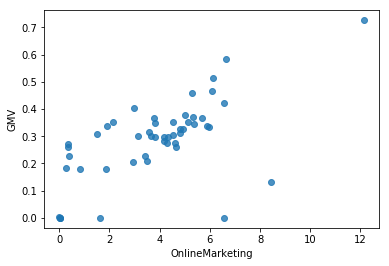

In [96]:
# Scater plot for GMV Generated by Sped type OnlineMarketing
sns.regplot(x="OnlineMarketing", y="GMV", data=WL_Game[['OnlineMarketing','GMV']], fit_reg=False)

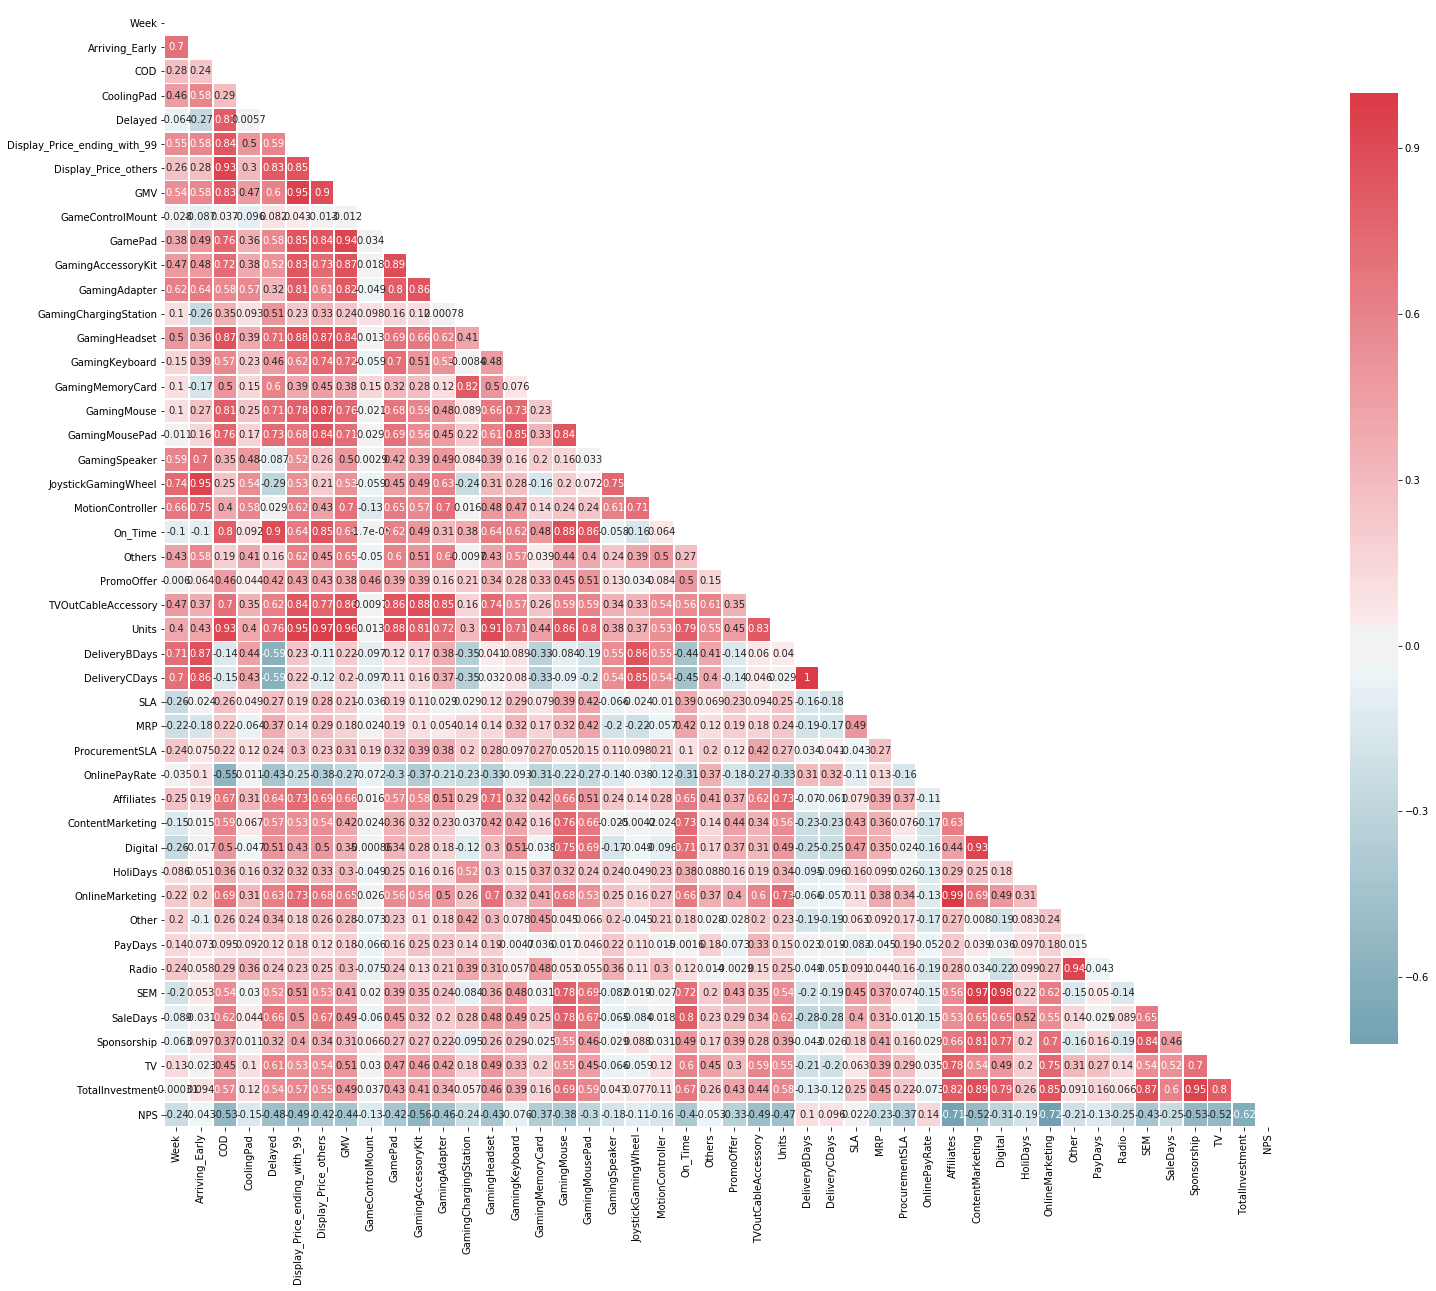

In [97]:
# Corelation matrix
corr=WL_Game.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot = True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.9, cbar_kws={"shrink": .7})

In [98]:
WL_Game.set_index("Week", inplace = True) 


In [99]:
WL_Game = WL_Game.drop(['ProductSubCategory'], axis=1)
WL_Game.head()

,Arriving_Early,COD,CoolingPad,Delayed,Display_Price_ending_with_99,Display_Price_others,GMV,GameControlMount,GamePad,GamingAccessoryKit,...,OnlineMarketing,Other,PayDays,Radio,SEM,SaleDays,Sponsorship,TV,TotalInvestment,NPS
Week,,,,,,,,,,,,,,,,,,,,,
27,19.0,0.0,0,7.0,11.0,16.0,0.003624,0,16.0,2.0,...,0.004157,0.0,6,0.0,0.015734,0,0.023221,0.000674,0.053435,54.599588
28,864.0,2203.0,0,1901.0,625.0,2363.0,0.269492,0,934.0,103.0,...,0.358542,0.0,0,0.0,1.357069,0,2.002843,0.058168,4.608958,54.599588
29,472.0,2068.0,0,1994.0,710.0,2012.0,0.227595,0,1556.0,130.0,...,0.372794,0.0,0,0.0,1.411013,2253,2.082456,0.060480,4.792165,54.599588
30,343.0,1918.0,0,1986.0,853.0,1635.0,0.260999,0,1055.0,167.0,...,0.349132,0.0,0,0.0,1.321452,0,1.950278,0.056641,4.487994,54.599588
31,300.0,1409.0,0,1392.0,665.0,1110.0,0.183931,0,694.0,96.0,...,0.265561,0.0,1,0.0,1.384702,0,1.547447,0.040359,4.051752,54.602646


In [102]:
# Creating AddStock variavle for all spend variable with R=50%

def calculate_ad_stocks(data, engagement_factor):
    
    #initialize ad stock vector
    ad_stock_vector = []
    #initialize ad_stock_value
    ad_stock_value = 0
    #loop through dataset to calculate ad stock values
    for index, row in data.iterrows():
        ad_stock_value = row[0] + ad_stock_value * engagement_factor
        ad_stock_vector.append(ad_stock_value)
    #add ad stock vector to dataset
    data['ad_stock'] = ad_stock_vector
    return data

TV_ad_stocks = calculate_ad_stocks(data=WL_Game[['TV']],engagement_factor=0.5)
TV_ad_stocks.columns = ['TV','TV_Ad_Stock'] 
WL_Game_M=pd.merge(WL_Game[['GMV','Units','NPS','PromoOffer','CoolingPad','Arriving_Early','On_Time','Delayed','GameControlMount', 'GamePad', 'GamingAccessoryKit', 'GamingAdapter','GamingChargingStation', 'GamingHeadset', 'GamingKeyboard','GamingMemoryCard', 'GamingMouse', 'GamingMousePad', 'GamingSpeaker','JoystickGamingWheel', 'MotionController','TVOutCableAccessory', 'Display_Price_ending_with_99','COD','PayDays','HoliDays','SaleDays']], TV_ad_stocks, on=['Week'], how='outer')

Affiliates_ad_stocks = calculate_ad_stocks(data=WL_Game[['Affiliates']],engagement_factor=0.5)
Affiliates_ad_stocks.columns = ['Affiliates','Affiliates_Ad_Stock'] 
WL_Game_M=pd.merge(WL_Game_M, Affiliates_ad_stocks, on=['Week'], how='outer')


ContentMarketing_ad_stocks = calculate_ad_stocks(data=WL_Game[['ContentMarketing']],engagement_factor=0.5)
ContentMarketing_ad_stocks.columns = ['ContentMarketing','ContentMarketing_Ad_Stock'] 
WL_Game_M=pd.merge(WL_Game_M, ContentMarketing_ad_stocks, on=['Week'], how='outer')

Digital_ad_stocks = calculate_ad_stocks(data=WL_Game[['Digital']],engagement_factor=0.5)
Digital_ad_stocks.columns = ['Digital','Digital_Ad_Stock'] 
WL_Game_M=pd.merge(WL_Game_M, Digital_ad_stocks, on=['Week'], how='outer')

OnlineMarketing_ad_stocks = calculate_ad_stocks(data=WL_Game[['OnlineMarketing']],engagement_factor=0.5)
OnlineMarketing_ad_stocks.columns = ['OnlineMarketing','OnlineMarketing_Ad_Stock'] 
WL_Game_M=pd.merge(WL_Game_M, OnlineMarketing_ad_stocks, on=['Week'], how='outer')

Other_ad_stocks = calculate_ad_stocks(data=WL_Game[['Other']],engagement_factor=0.5)
Other_ad_stocks.columns = ['Other','Other_Ad_Stock'] 
WL_Game_M=pd.merge(WL_Game_M, Other_ad_stocks, on=['Week'], how='outer')

Radio_ad_stocks = calculate_ad_stocks(data=WL_Game[['Radio']],engagement_factor=0.5)
Radio_ad_stocks.columns = ['Radio','Radio_Ad_Stock'] 
WL_Game_M=pd.merge(WL_Game_M, Radio_ad_stocks, on=['Week'], how='outer')

SEM_ad_stocks = calculate_ad_stocks(data=WL_Game[['SEM']],engagement_factor=0.5)
SEM_ad_stocks.columns = ['SEM','SEM_Ad_Stock'] 
WL_Game_M=pd.merge(WL_Game_M, SEM_ad_stocks, on=['Week'], how='outer')

Sponsorship_ad_stocks = calculate_ad_stocks(data=WL_Game[['Sponsorship']],engagement_factor=0.5)
Sponsorship_ad_stocks.columns = ['Sponsorship','Sponsorship_Ad_Stock'] 
WL_Game_M=pd.merge(WL_Game_M, Sponsorship_ad_stocks, on=['Week'], how='outer')

In [103]:
WL_Game_M.head()

,GMV,Units,NPS,PromoOffer,CoolingPad,Arriving_Early,On_Time,Delayed,GameControlMount,GamePad,...,OnlineMarketing,OnlineMarketing_Ad_Stock,Other,Other_Ad_Stock,Radio,Radio_Ad_Stock,SEM,SEM_Ad_Stock,Sponsorship,Sponsorship_Ad_Stock
Week,,,,,,,,,,,,,,,,,,,,,
27,0.003624,28,54.599588,62.496169,0,19.0,1.0,7.0,0,16.0,...,0.004157,0.004157,0.0,0.0,0.0,0.0,0.015734,0.015734,0.023221,0.023221
28,0.269492,3120,54.599588,3722.171292,0,864.0,223.0,1901.0,0,934.0,...,0.358542,0.360621,0.0,0.0,0.0,0.0,1.357069,1.364936,2.002843,2.014453
29,0.227595,2849,54.599588,4746.911016,0,472.0,256.0,1994.0,0,1556.0,...,0.372794,0.553105,0.0,0.0,0.0,0.0,1.411013,2.093481,2.082456,3.089683
30,0.260999,2581,54.599588,3576.199903,0,343.0,159.0,1986.0,0,1055.0,...,0.349132,0.625684,0.0,0.0,0.0,0.0,1.321452,2.368193,1.950278,3.495119
31,0.183931,1845,54.602646,9101.134720,0,300.0,83.0,1392.0,0,694.0,...,0.265561,0.578403,0.0,0.0,0.0,0.0,1.384702,2.568798,1.547447,3.295006


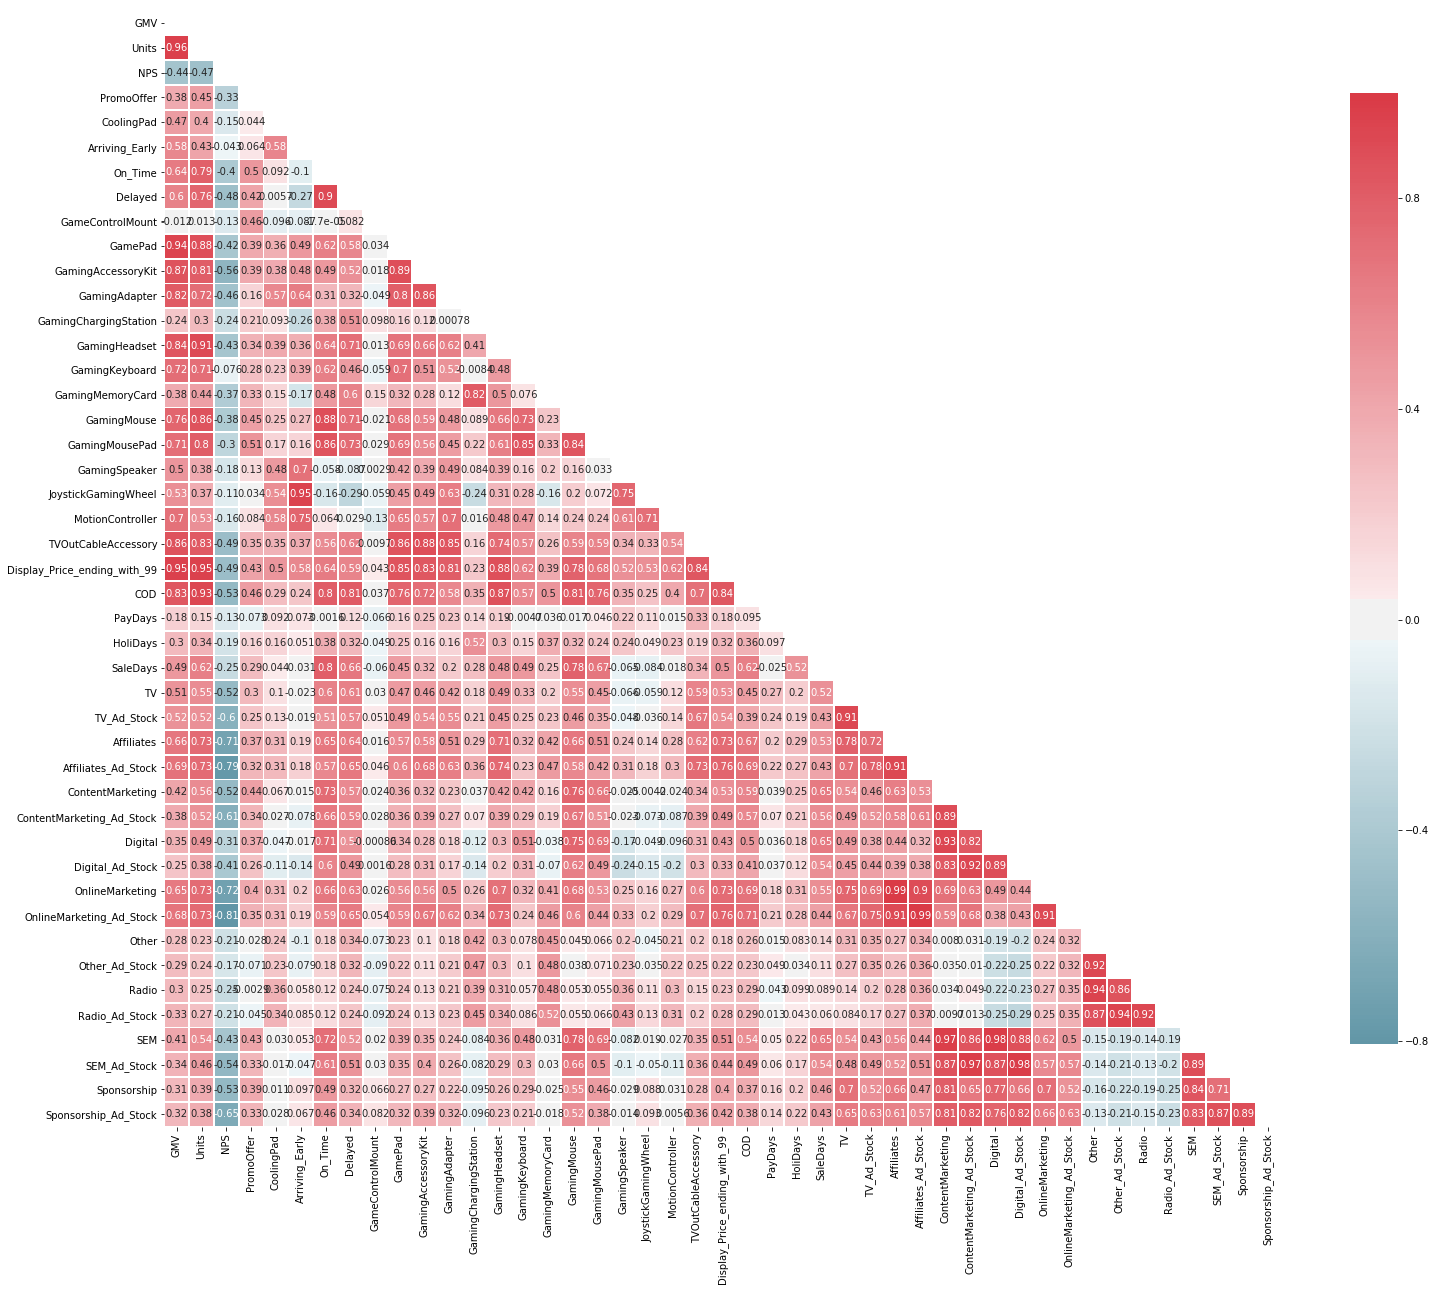

In [104]:
# Corelation matrix
corr=WL_Game_M.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot = True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.9, cbar_kws={"shrink": .7})

# Splitting the data into training nad test data
We have to specify this so that the train and test data set always have the same rows, respectively

In [219]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(WL_Game_M, train_size = 0.7, test_size = 0.3, random_state = 100)

In [220]:
# Creating Predicter and influencer variable for Lenier Model 
y_train = df_train.pop('GMV')
X_train = df_train

In [221]:
# RFE to identify significant variavles in Media spend
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)
# variables with ranking
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Units', False, 17),
 ('NPS', True, 1),
 ('PromoOffer', False, 25),
 ('CoolingPad', True, 1),
 ('Arriving_Early', False, 10),
 ('On_Time', False, 15),
 ('Delayed', False, 9),
 ('GameControlMount', True, 1),
 ('GamePad', False, 12),
 ('GamingAccessoryKit', False, 5),
 ('GamingAdapter', False, 4),
 ('GamingChargingStation', False, 3),
 ('GamingHeadset', False, 11),
 ('GamingKeyboard', False, 13),
 ('GamingMemoryCard', False, 14),
 ('GamingMouse', False, 8),
 ('GamingMousePad', False, 19),
 ('GamingSpeaker', False, 6),
 ('JoystickGamingWheel', False, 7),
 ('MotionController', False, 18),
 ('TVOutCableAccessory', False, 16),
 ('Display_Price_ending_with_99', False, 20),
 ('COD', False, 21),
 ('PayDays', False, 22),
 ('HoliDays', False, 23),
 ('SaleDays', False, 24),
 ('TV', True, 1),
 ('TV_Ad_Stock', True, 1),
 ('Affiliates', True, 1),
 ('Affiliates_Ad_Stock', True, 1),
 ('ContentMarketing', True, 1),
 ('ContentMarketing_Ad_Stock', True, 1),
 ('Digital', True, 1),
 ('Digital_Ad_Stock', T

In [222]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['Units', 'PromoOffer', 'Arriving_Early', 'On_Time', 'Delayed',
       'GamePad', 'GamingAccessoryKit', 'GamingAdapter',
       'GamingChargingStation', 'GamingHeadset', 'GamingKeyboard',
       'GamingMemoryCard', 'GamingMouse', 'GamingMousePad', 'GamingSpeaker',
       'JoystickGamingWheel', 'MotionController', 'TVOutCableAccessory',
       'Display_Price_ending_with_99', 'COD', 'PayDays', 'HoliDays',
       'SaleDays', 'Sponsorship_Ad_Stock'],
      dtype='object')

In [223]:
import statsmodels.api as sm
# build simple simple lenier model

X_train = X_train[col]
X_train_lm = sm.add_constant(X_train)
lr1 = sm.OLS(y_train, X_train_lm).fit()

# View summary
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     52.26
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           7.26e-10
Time:                        11:38:18   Log-Likelihood:                 96.173
No. Observations:                  35   AIC:                            -150.3
Df Residuals:                      14   BIC:                            -117.7
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [224]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
18,SEM,32827.23
10,Digital,20926.04
19,SEM_Ad_Stock,18963.44
13,OnlineMarketing_Ad_Stock,14086.03
14,Other,12780.26
7,Affiliates_Ad_Stock,12771.61
11,Digital_Ad_Stock,12058.71
16,Radio,11549.57
15,Other_Ad_Stock,10569.51
12,OnlineMarketing,9526.73


In [225]:

# Affiliates_Ad_Stock has p value of 0.991 (not significant) with VIF 22216.80 which is insignificatant so drop this variable
X_train = X_train.drop(['SEM_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr2 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     58.93
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           9.17e-11
Time:                        11:38:20   Log-Likelihood:                 96.172
No. Observations:                  35   AIC:                            -152.3
Df Residuals:                      15   BIC:                            -121.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [226]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
13,OnlineMarketing_Ad_Stock,9486.35
7,Affiliates_Ad_Stock,7514.59
12,OnlineMarketing,7503.85
6,Affiliates,5356.37
14,Other,4311.25
16,Radio,3699.08
18,SEM,3588.31
15,Other_Ad_Stock,3129.37
17,Radio_Ad_Stock,2763.66
0,const,2392.70


In [227]:
# OnlineMarketing has p value of 0.747 (not significant) with VIF 6384.98 which is insignificatant so drop this variable
X_train = X_train.drop(['OnlineMarketing_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr3 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr3.summary())


                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     65.79
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.17e-11
Time:                        11:38:23   Log-Likelihood:                 96.024
No. Observations:                  35   AIC:                            -154.0
Df Residuals:                      16   BIC:                            -124.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [228]:
#  p value of 0.899 (not significant) with VIF 2324.61 which is insignificatant so drop this variable
X_train = X_train.drop(['GameControlMount'], 1,)
X_train_lm = sm.add_constant(X_train)
lr4 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr4.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     73.38
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.41e-12
Time:                        11:38:24   Log-Likelihood:                 95.875
No. Observations:                  35   AIC:                            -155.8
Df Residuals:                      17   BIC:                            -127.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [229]:
# Digital_Ad_Stock has p value of 0.805 (not significant) with VIF 235.32 which is insignificatant so drop this variable
X_train = X_train.drop(['Affiliates_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr5 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr5.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     80.65
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.85e-13
Time:                        11:38:26   Log-Likelihood:                 95.473
No. Observations:                  35   AIC:                            -156.9
Df Residuals:                      18   BIC:                            -130.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [230]:
# SEM has p value of 0.610 (not significant) with VIF 2076.10 which is insignificatant so drop this variable
X_train = X_train.drop(['Digital_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr6 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr6.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     85.55
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           3.27e-14
Time:                        11:38:27   Log-Likelihood:                 94.445
No. Observations:                  35   AIC:                            -156.9
Df Residuals:                      19   BIC:                            -132.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [231]:
# Other has p value of 0.521 (not significant) with VIF 22.43 which is insignificatant so drop this variable
X_train = X_train.drop(['ContentMarketing_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr7 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr7.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     93.65
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           4.32e-15
Time:                        11:38:29   Log-Likelihood:                 93.931
No. Observations:                  35   AIC:                            -157.9
Df Residuals:                      20   BIC:                            -134.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6664      0.160  

In [232]:
# Sponsorship_Ad_Stock has p value of 0.287 (not significant) with VIF 44.23 which is insignificatant so drop this variable
X_train = X_train.drop(['ContentMarketing'], 1,)
X_train_lm = sm.add_constant(X_train)
lr8 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr8.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     95.38
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.19e-15
Time:                        11:38:30   Log-Likelihood:                 92.128
No. Observations:                  35   AIC:                            -156.3
Df Residuals:                      21   BIC:                            -134.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7809      0.143     

In [233]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
12,SEM,2087.44
5,Affiliates,1844.04
7,OnlineMarketing,1820.93
6,Digital,1539.15
0,const,1421.02
8,Other,1223.96
10,Radio,1121.48
3,TV,350.61
9,Other_Ad_Stock,240.72
11,Radio_Ad_Stock,225.04


In [234]:
# TV has p value of 0.718 (not significant) with VIF 32.33 which is insignificatant so drop this variable
X_train = X_train.drop(['SEM'], 1,)
X_train_lm = sm.add_constant(X_train)
lr9 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr9.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     20.03
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           4.23e-09
Time:                        11:38:32   Log-Likelihood:                 63.839
No. Observations:                  35   AIC:                            -101.7
Df Residuals:                      22   BIC:                            -81.46
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4174      0.302     

In [235]:
# Affiliates has p value of 0.017 (not significant) with VIF 17.05 which is insignificatant so drop this variable
X_train = X_train.drop(['Radio'], 1,)
X_train_lm = sm.add_constant(X_train)
lr10 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr10.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     22.51
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           9.87e-10
Time:                        11:38:34   Log-Likelihood:                 63.606
No. Observations:                  35   AIC:                            -103.2
Df Residuals:                      23   BIC:                            -84.55
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3965      0.295     

In [236]:
# Affiliates_Ad_Stock has p value of 0.052 (not significant) with VIF 633.44 which is insignificatant so drop this variable
X_train = X_train.drop(['Other'], 1,)
X_train_lm = sm.add_constant(X_train)
lr11 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr11.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     21.99
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.02e-09
Time:                        11:38:35   Log-Likelihood:                 61.045
No. Observations:                  35   AIC:                            -100.1
Df Residuals:                      24   BIC:                            -82.98
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6660      0.272     

In [237]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,993.19
7,OnlineMarketing,913.41
5,Affiliates,832.59
8,Other_Ad_Stock,127.62
9,Radio_Ad_Stock,112.35
3,TV,66.82
10,Sponsorship,58.75
4,TV_Ad_Stock,21.39
6,Digital,9.38
1,NPS,5.49


In [238]:
# Sponsorship has p value of 0.114 (not significant) with VIF 8.01 which is insignificatant so drop this variable
X_train = X_train.drop(['Radio_Ad_Stock'], 1,)
X_train_lm = sm.add_constant(X_train)
lr12 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr12.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     25.40
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.99e-10
Time:                        11:38:38   Log-Likelihood:                 61.011
No. Observations:                  35   AIC:                            -102.0
Df Residuals:                      25   BIC:                            -86.47
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6428      0.245     

In [239]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,OnlineMarketing,854.87
0,const,838.56
5,Affiliates,805.79
3,TV,56.20
9,Sponsorship,56.20
4,TV_Ad_Stock,17.65
6,Digital,8.38
1,NPS,4.71
8,Other_Ad_Stock,3.76
2,CoolingPad,1.63


In [240]:
# Affiliates_Ad_Stock has p value of 0.052 (not significant) with VIF 633.44 which is insignificatant so drop this variable
X_train = X_train.drop(['TV'], 1,)
X_train_lm = sm.add_constant(X_train)
lr11 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr11.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     29.00
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           4.62e-11
Time:                        11:38:40   Log-Likelihood:                 60.624
No. Observations:                  35   AIC:                            -103.2
Df Residuals:                      26   BIC:                            -89.25
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7485      0.199     

In [241]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,559.99
6,OnlineMarketing,436.18
4,Affiliates,373.01
8,Sponsorship,18.94
5,Digital,7.45
3,TV_Ad_Stock,7.23
1,NPS,3.45
7,Other_Ad_Stock,2.26
2,CoolingPad,1.56


In [242]:
#ContentMarketing has VIF 51.57 which is insignificatant so drop this variable
X_train = X_train.drop(['Digital'], 1,)
X_train_lm = sm.add_constant(X_train)
lr13 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr13.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     32.13
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.69e-11
Time:                        11:38:43   Log-Likelihood:                 59.546
No. Observations:                  35   AIC:                            -103.1
Df Residuals:                      27   BIC:                            -90.65
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8083      0.195     

In [243]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,529.22
5,OnlineMarketing,427.36
4,Affiliates,366.09
7,Sponsorship,12.35
3,TV_Ad_Stock,7.12
1,NPS,3.22
6,Other_Ad_Stock,2.25
2,CoolingPad,1.41


In [244]:
# Other_Ad_Stock has p value of 0.126 (not significant) with VIF 14.80 which is insignificatant so drop this variable
X_train = X_train.drop(['OnlineMarketing'], 1,)
X_train_lm = sm.add_constant(X_train)
lr14 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr14.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     18.20
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.71e-08
Time:                        11:38:51   Log-Likelihood:                 48.277
No. Observations:                  35   AIC:                            -82.55
Df Residuals:                      28   BIC:                            -71.67
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3768      0.237      1.

In [245]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,423.51
4,Affiliates,4.14
6,Sponsorship,3.17
3,TV_Ad_Stock,2.94
1,NPS,2.51
5,Other_Ad_Stock,2.03
2,CoolingPad,1.24


In [246]:
# Other_Ad_Stock has p value of 0.126 (not significant) with VIF 14.80 which is insignificatant so drop this variable
X_train = X_train.drop(['CoolingPad'], 1,)
X_train_lm = sm.add_constant(X_train)
lr15 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr15.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     21.69
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           5.38e-09
Time:                        11:39:07   Log-Likelihood:                 47.694
No. Observations:                  35   AIC:                            -83.39
Df Residuals:                      29   BIC:                            -74.06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3774      0.237      1.

In [247]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,423.50
3,Affiliates,3.81
5,Sponsorship,3.17
2,TV_Ad_Stock,2.85
1,NPS,2.51
4,Other_Ad_Stock,1.99


In [248]:
# Other_Ad_Stock has p value of 0.126 (not significant) with VIF 14.80 which is insignificatant so drop this variable
X_train = X_train.drop(['NPS'], 1,)
X_train_lm = sm.add_constant(X_train)
lr16 = sm.OLS(y_train, X_train_lm).fit()

# Print the summary of the model
print(lr16.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     26.75
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.62e-09
Time:                        11:39:33   Log-Likelihood:                 47.046
No. Observations:                  35   AIC:                            -84.09
Df Residuals:                      30   BIC:                            -76.32
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1311      0.024      5.

In [249]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,4.18
4,Sponsorship,3.12
2,Affiliates,2.80
1,TV_Ad_Stock,2.53
3,Other_Ad_Stock,1.93


Text(0.5,0,'Errors')

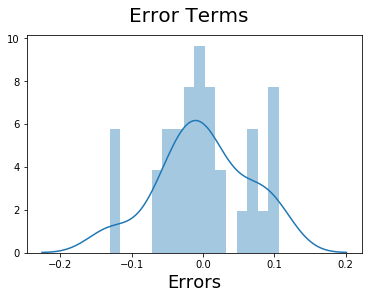

In [250]:
# Testing Error Rate
y_train_GMV = lr16.predict(X_train_lm)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_GMV), bins = 16)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18) 

# Making Predictions Using the Final Model
Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final, i.e. fourth model.

Applying the scaling on the test sets

In [251]:
y_test=df_test.pop('GMV')
X_test=df_test

In [285]:
# Now let's use our model to make predictions.
# Creating X_test_new dataframe 

X_test_new=X_test[['Other_Ad_Stock','TV_Ad_Stock','Sponsorship','Affiliates']]

X_test_new = sm.add_constant(X_test_new)

In [286]:
# Making predictions
y_pred = lr16.predict(X_test_new)
y_pred

Week
40    0.882221
70    0.620747
71    0.400577
62    0.470569
77    0.300477
38    0.261284
37    0.640113
67    0.504610
54    0.161400
76    0.299116
27    0.131439
45    0.544759
52    0.688541
79    0.231890
72    0.312632
dtype: float64

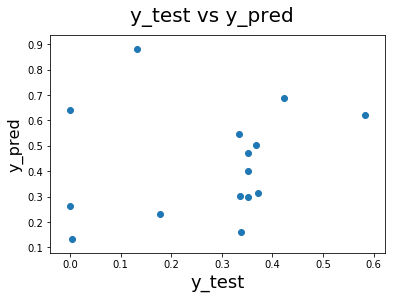

In [287]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

plt.show()

### Mulitipliative Model for Camera Accessories

In [291]:
# Creating dataset for building Multiplicative Model and Distributive Lag Model.
WL_Game_MM = WL_Game_M.copy()
WL_Game_DM = WL_Game_M.copy()

In [293]:
#Assigning least value possible instead of 0, Since log(0) gives infinite.
WL_Game_MM[WL_Game_MM == 0]=0.00001

In [294]:
#Converting the whole dataframe to logarathmic dataframe
WL_Game_MM_log = np.log(WL_Game_MM)
WL_Game_MM_log.head(5)

,GMV,Units,NPS,PromoOffer,CoolingPad,Arriving_Early,On_Time,Delayed,GameControlMount,GamePad,...,OnlineMarketing,OnlineMarketing_Ad_Stock,Other,Other_Ad_Stock,Radio,Radio_Ad_Stock,SEM,SEM_Ad_Stock,Sponsorship,Sponsorship_Ad_Stock
Week,,,,,,,,,,,,,,,,,,,,,
27,-5.620204,3.332205,4.000026,4.135105,-11.512925,2.944439,0.000000,1.945910,-11.512925,2.772589,...,-5.482991,-5.482991,-11.512925,-11.512925,-11.512925,-11.512925,-4.151955,-4.151955,-3.762714,-3.762714
28,-1.311217,8.045588,4.000026,8.222062,-11.512925,6.761573,5.407172,7.550135,-11.512925,6.839476,...,-1.025709,-1.019929,-11.512925,-11.512925,-11.512925,-11.512925,0.305327,0.311108,0.694568,0.700348
29,-1.480186,7.954723,4.000026,8.465249,-11.512925,6.156979,5.545177,7.597898,-11.512925,7.349874,...,-0.986728,-0.592208,-11.512925,-11.512925,-11.512925,-11.512925,0.344308,0.738828,0.733548,1.128069
30,-1.343239,7.855932,4.000026,8.182056,-11.512925,5.837730,5.068904,7.593878,-11.512925,6.961296,...,-1.052305,-0.468909,-11.512925,-11.512925,-11.512925,-11.512925,0.278731,0.862127,0.667972,1.251367
31,-1.693194,7.520235,4.000082,9.116154,-11.512925,5.703782,4.418841,7.238497,-11.512925,6.542472,...,-1.325912,-0.547485,-11.512925,-11.512925,-11.512925,-11.512925,0.325485,0.943438,0.436606,1.192408


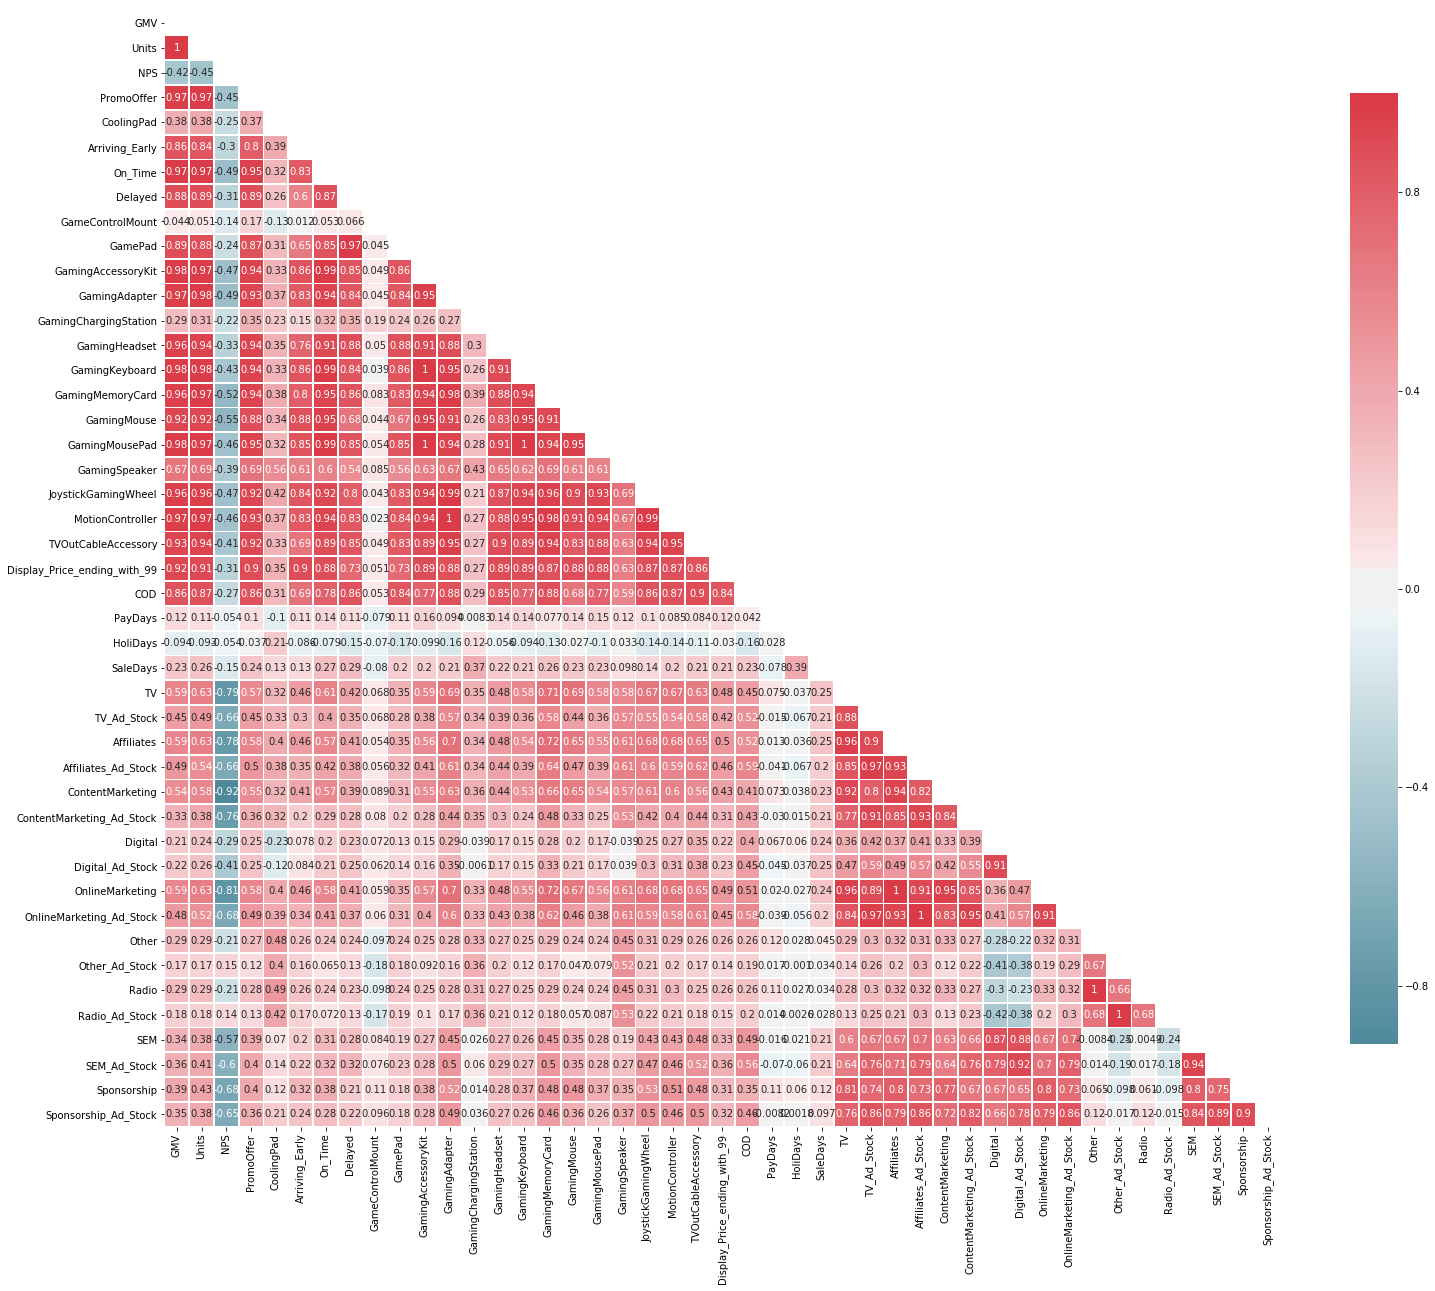

In [295]:
# Corelation matrix
corr=WL_Game_MM_log.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot = True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.9, cbar_kws={"shrink": .7})

In [296]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(WL_Game_MM_log, train_size = 0.7, test_size = 0.3, random_state = 100)

In [297]:
# Creating Predicter and influencer variable for Linear Model 
y_train = df_train.pop('GMV')
X_train = df_train

In [298]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)
# variables with ranking
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Units', True, 1),
 ('NPS', True, 1),
 ('PromoOffer', False, 5),
 ('CoolingPad', False, 21),
 ('Arriving_Early', True, 1),
 ('On_Time', True, 1),
 ('Delayed', True, 1),
 ('GameControlMount', False, 17),
 ('GamePad', True, 1),
 ('GamingAccessoryKit', True, 1),
 ('GamingAdapter', False, 7),
 ('GamingChargingStation', False, 24),
 ('GamingHeadset', False, 9),
 ('GamingKeyboard', False, 18),
 ('GamingMemoryCard', False, 16),
 ('GamingMouse', False, 10),
 ('GamingMousePad', True, 1),
 ('GamingSpeaker', False, 19),
 ('JoystickGamingWheel', False, 14),
 ('MotionController', False, 13),
 ('TVOutCableAccessory', False, 6),
 ('Display_Price_ending_with_99', False, 11),
 ('COD', False, 8),
 ('PayDays', False, 25),
 ('HoliDays', False, 20),
 ('SaleDays', False, 23),
 ('TV', False, 2),
 ('TV_Ad_Stock', False, 15),
 ('Affiliates', True, 1),
 ('Affiliates_Ad_Stock', True, 1),
 ('ContentMarketing', True, 1),
 ('ContentMarketing_Ad_Stock', True, 1),
 ('Digital', False, 12),
 ('Digital_Ad_Stock', True

In [299]:
# Building simple linear model with log values which gives the Multiplicative Model
#Iteration 1 - CA MM
import statsmodels.api as sm

col = X_train.columns[rfe.support_]
X_train_lm = X_train[col]
X_train_lm = sm.add_constant(X_train_lm)
lm1 = sm.OLS(y_train,X_train_lm).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     553.6
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           5.81e-17
Time:                        11:51:24   Log-Likelihood:                 41.096
No. Observations:                  35   AIC:                            -40.19
Df Residuals:                      14   BIC:                            -7.530
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [300]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,371668.71
15,OnlineMarketing_Ad_Stock,63837.09
14,OnlineMarketing,61673.20
9,Affiliates,53292.79
10,Affiliates_Ad_Stock,48954.03
16,Other_Ad_Stock,3718.41
17,Radio_Ad_Stock,3659.54
11,ContentMarketing,3567.29
12,ContentMarketing_Ad_Stock,2321.67
7,GamingAccessoryKit,1427.00


In [301]:
# Dropping Affilates and creating model.
#Iteration 2 - CA MM
X_train_lm = X_train_lm.drop(['OnlineMarketing_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm2 = sm.OLS(y_train,X_train_lm).fit() 
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     616.0
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.49e-18
Time:                        11:52:36   Log-Likelihood:                 40.862
No. Observations:                  35   AIC:                            -41.72
Df Residuals:                      15   BIC:                            -10.62
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [302]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,302261.74
14,OnlineMarketing,31833.41
9,Affiliates,28023.54
15,Other_Ad_Stock,3616.87
16,Radio_Ad_Stock,3583.53
11,ContentMarketing,3426.86
12,ContentMarketing_Ad_Stock,1347.96
4,On_Time,1342.88
7,GamingAccessoryKit,1284.08
8,GamingMousePad,822.11


In [303]:
X_train_lm = X_train_lm.drop(['NPS'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm3 = sm.OLS(y_train,X_train_lm).fit() 
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     653.7
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.47e-19
Time:                        11:53:03   Log-Likelihood:                 39.827
No. Observations:                  35   AIC:                            -41.65
Df Residuals:                      16   BIC:                            -12.10
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [304]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,59127.12
13,OnlineMarketing,30481.24
8,Affiliates,26958.67
14,Other_Ad_Stock,3573.66
15,Radio_Ad_Stock,3488.77
10,ContentMarketing,3297.99
3,On_Time,1325.89
11,ContentMarketing_Ad_Stock,1325.35
6,GamingAccessoryKit,1283.58
7,GamingMousePad,822.04


In [305]:
X_train_lm = X_train_lm.drop(['Affiliates_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm4 = sm.OLS(y_train,X_train_lm).fit() 
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     675.3
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.09e-20
Time:                        11:53:50   Log-Likelihood:                 38.337
No. Observations:                  35   AIC:                            -40.67
Df Residuals:                      17   BIC:                            -12.68
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [306]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,57482.30
12,OnlineMarketing,30031.13
8,Affiliates,26778.70
9,ContentMarketing,3064.30
13,Other_Ad_Stock,2774.24
14,Radio_Ad_Stock,2736.34
3,On_Time,1308.33
6,GamingAccessoryKit,1095.21
10,ContentMarketing_Ad_Stock,1048.88
7,GamingMousePad,789.74


In [307]:
X_train_lm = X_train_lm.drop(['On_Time'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm5 = sm.OLS(y_train,X_train_lm).fit() 
print(lm5.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     659.7
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.36e-21
Time:                        11:54:12   Log-Likelihood:                 35.870
No. Observations:                  35   AIC:                            -37.74
Df Residuals:                      18   BIC:                            -11.30
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [308]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,54550.07
11,OnlineMarketing,27667.72
7,Affiliates,24067.65
12,Other_Ad_Stock,2749.04
13,Radio_Ad_Stock,2720.95
8,ContentMarketing,2043.19
5,GamingAccessoryKit,1032.47
9,ContentMarketing_Ad_Stock,720.52
1,Units,717.38
6,GamingMousePad,455.36


In [309]:
X_train_lm = X_train_lm.drop(['SEM_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm6 = sm.OLS(y_train,X_train_lm).fit() 
print(lm6.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     633.9
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.17e-22
Time:                        11:55:14   Log-Likelihood:                 33.103
No. Observations:                  35   AIC:                            -34.21
Df Residuals:                      19   BIC:                            -9.320
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [310]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,52022.77
11,OnlineMarketing,23448.55
7,Affiliates,20458.71
12,Other_Ad_Stock,2747.92
13,Radio_Ad_Stock,2720.88
8,ContentMarketing,1560.21
5,GamingAccessoryKit,946.09
1,Units,665.67
9,ContentMarketing_Ad_Stock,568.96
6,GamingMousePad,455.35


In [311]:
X_train_lm = X_train_lm.drop(['OnlineMarketing'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm7 = sm.OLS(y_train,X_train_lm).fit() 
print(lm7.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     469.7
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           5.17e-22
Time:                        11:56:02   Log-Likelihood:                 25.770
No. Observations:                  35   AIC:                            -21.54
Df Residuals:                      20   BIC:                             1.791
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [312]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,15804.44
12,Radio_Ad_Stock,2425.19
11,Other_Ad_Stock,2399.00
5,GamingAccessoryKit,932.30
8,ContentMarketing,696.63
1,Units,652.16
9,ContentMarketing_Ad_Stock,482.86
6,GamingMousePad,444.86
7,Affiliates,421.33
4,GamePad,332.61


In [313]:
X_train_lm = X_train_lm.drop(['Radio_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm8 = sm.OLS(y_train,X_train_lm).fit() 
print(lm8.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     251.0
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           5.41e-20
Time:                        11:56:18   Log-Likelihood:                 12.709
No. Observations:                  35   AIC:                             2.582
Df Residuals:                      21   BIC:                             24.36
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [314]:
X_train_lm = X_train_lm.drop(['Affiliates'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm9 = sm.OLS(y_train,X_train_lm).fit() 
print(lm9.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     280.6
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           3.65e-21
Time:                        11:56:37   Log-Likelihood:                 12.450
No. Observations:                  35   AIC:                             1.101
Df Residuals:                      22   BIC:                             21.32
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [315]:
X_train_lm = X_train_lm.drop(['GamingMousePad'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm10 = sm.OLS(y_train,X_train_lm).fit() 
print(lm10.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     305.1
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           3.41e-22
Time:                        11:56:55   Log-Likelihood:                 11.617
No. Observations:                  35   AIC:                            0.7662
Df Residuals:                      23   BIC:                             19.43
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [316]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,1643.73
5,GamingAccessoryKit,399.13
6,ContentMarketing,317.33
4,GamePad,251.38
1,Units,210.27
7,ContentMarketing_Ad_Stock,91.48
3,Delayed,73.88
10,SEM,35.28
8,Digital_Ad_Stock,18.78
11,Sponsorship_Ad_Stock,10.20


In [317]:
X_train_lm = X_train_lm.drop(['GamePad'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm11 = sm.OLS(y_train,X_train_lm).fit() 
print(lm11.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     336.8
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.79e-23
Time:                        11:57:22   Log-Likelihood:                 10.943
No. Observations:                  35   AIC:                            0.1144
Df Residuals:                      24   BIC:                             17.22
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [318]:
X_train_lm = X_train_lm.drop(['ContentMarketing_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm12 = sm.OLS(y_train,X_train_lm).fit() 
print(lm12.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     357.6
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           3.97e-24
Time:                        11:57:46   Log-Likelihood:                 9.4401
No. Observations:                  35   AIC:                             1.120
Df Residuals:                      25   BIC:                             16.67
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -10.4924 

In [319]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,1424.47
1,Units,147.02
4,GamingAccessoryKit,109.98
3,Delayed,39.37
5,ContentMarketing,12.18
8,SEM,9.39
6,Digital_Ad_Stock,8.77
9,Sponsorship_Ad_Stock,7.95
2,Arriving_Early,5.62
7,Other_Ad_Stock,3.72


In [320]:
X_train_lm = X_train_lm.drop(['GamingAccessoryKit'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm13 = sm.OLS(y_train,X_train_lm).fit() 
print(lm13.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     409.1
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.48e-25
Time:                        11:58:10   Log-Likelihood:                 9.0514
No. Observations:                  35   AIC:                           -0.1027
Df Residuals:                      26   BIC:                             13.90
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -11.4451 

In [321]:


# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,240.83
1,Units,45.35
3,Delayed,39.23
4,ContentMarketing,12.17
5,Digital_Ad_Stock,8.53
8,Sponsorship_Ad_Stock,7.40
7,SEM,5.51
2,Arriving_Early,5.30
6,Other_Ad_Stock,2.48


In [322]:
X_train_lm = X_train_lm.drop(['Other_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm13 = sm.OLS(y_train,X_train_lm).fit() 
print(lm13.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     476.3
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.39e-26
Time:                        11:59:00   Log-Likelihood:                 8.7201
No. Observations:                  35   AIC:                            -1.440
Df Residuals:                      27   BIC:                             11.00
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -11.3877 

In [323]:
X_train_lm = X_train_lm.drop(['SEM'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm13 = sm.OLS(y_train,X_train_lm).fit() 
print(lm13.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     567.1
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           6.88e-28
Time:                        11:59:23   Log-Likelihood:                 8.4403
No. Observations:                  35   AIC:                            -2.881
Df Residuals:                      28   BIC:                             8.007
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -11.3431 

In [324]:
X_train_lm = X_train_lm.drop(['Arriving_Early'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm14 = sm.OLS(y_train,X_train_lm).fit() 
print(lm14.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     673.2
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           4.72e-29
Time:                        11:59:51   Log-Likelihood:                 7.6448
No. Observations:                  35   AIC:                            -3.290
Df Residuals:                      29   BIC:                             6.043
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -11.3523 

In [325]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,232.37
2,Delayed,25.77
1,Units,19.15
3,ContentMarketing,9.26
5,Sponsorship_Ad_Stock,6.53
4,Digital_Ad_Stock,3.87


In [326]:
X_train_lm = X_train_lm.drop(['Delayed'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
lm15 = sm.OLS(y_train,X_train_lm).fit() 
print(lm15.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     836.8
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.69e-30
Time:                        12:00:14   Log-Likelihood:                 6.9580
No. Observations:                  35   AIC:                            -3.916
Df Residuals:                      30   BIC:                             3.861
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -10.9989 

In [327]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,149.89
2,ContentMarketing,6.01
1,Units,3.76
4,Sponsorship_Ad_Stock,3.40
3,Digital_Ad_Stock,1.71


Text(0.5,0,'Errors')

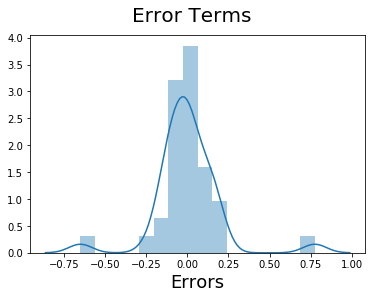

In [328]:
# Testing Error Rate
y_train_GMV = lm15.predict(X_train_lm)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_GMV), bins = 16)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18) 

In [329]:
y_test=df_test.pop('GMV')
X_test=df_test
# Now let's use our model to make predictions.
# Creating X_test_new dataframe 



In [333]:
X_test_new=X_test[['Units','Sponsorship_Ad_Stock','Digital_Ad_Stock','ContentMarketing']]

X_test_new = sm.add_constant(X_test_new)
# Making predictions
y_pred = lm15.predict(X_test_new)
y_pred

Week
40    -3.264988
70    -1.784185
71    -2.112041
62    -1.962422
77    -2.608613
38   -11.472404
37   -11.453654
67    -2.732696
54    -1.923204
76    -2.526707
27    -8.562966
45    -2.319950
52    -1.707708
79    -3.518759
72    -1.879119
dtype: float64

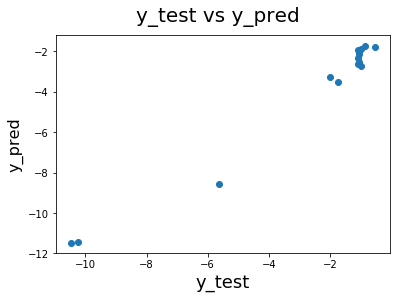

In [334]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

plt.show()

In [335]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8044824138993536

# Distributive Model for Camera Accessories

In [336]:
#Creating Lag Variables for GMV Camera Accessory.
CA_Lag =WL_Game_DM
CA_Lag['GMV_Lag_1'] = WL_Game_DM.GMV.shift(1)
CA_Lag['GMV_Lag_2'] = WL_Game_DM.GMV.shift(2)
CA_Lag['GMV_Lag_3'] = WL_Game_DM.GMV.shift(3)
CA_Lag.head()

,GMV,Units,NPS,PromoOffer,CoolingPad,Arriving_Early,On_Time,Delayed,GameControlMount,GamePad,...,Other_Ad_Stock,Radio,Radio_Ad_Stock,SEM,SEM_Ad_Stock,Sponsorship,Sponsorship_Ad_Stock,GMV_Lag_1,GMV_Lag_2,GMV_Lag_3
Week,,,,,,,,,,,,,,,,,,,,,
27,0.003624,28,54.599588,62.496169,0,19.0,1.0,7.0,0,16.0,...,0.0,0.0,0.0,0.015734,0.015734,0.023221,0.023221,NaN,NaN,NaN
28,0.269492,3120,54.599588,3722.171292,0,864.0,223.0,1901.0,0,934.0,...,0.0,0.0,0.0,1.357069,1.364936,2.002843,2.014453,0.003624,NaN,NaN
29,0.227595,2849,54.599588,4746.911016,0,472.0,256.0,1994.0,0,1556.0,...,0.0,0.0,0.0,1.411013,2.093481,2.082456,3.089683,0.269492,0.003624,NaN
30,0.260999,2581,54.599588,3576.199903,0,343.0,159.0,1986.0,0,1055.0,...,0.0,0.0,0.0,1.321452,2.368193,1.950278,3.495119,0.227595,0.269492,0.003624
31,0.183931,1845,54.602646,9101.134720,0,300.0,83.0,1392.0,0,694.0,...,0.0,0.0,0.0,1.384702,2.568798,1.547447,3.295006,0.260999,0.227595,0.269492


In [337]:
#Replacing NaN with 0.
CA_Lag.fillna(0)

,GMV,Units,NPS,PromoOffer,CoolingPad,Arriving_Early,On_Time,Delayed,GameControlMount,GamePad,...,Other_Ad_Stock,Radio,Radio_Ad_Stock,SEM,SEM_Ad_Stock,Sponsorship,Sponsorship_Ad_Stock,GMV_Lag_1,GMV_Lag_2,GMV_Lag_3
Week,,,,,,,,,,,,,,,,,,,,,
27,0.003624,28,54.599588,62.496169,0,19.0,1.0,7.0,0,16.0,...,0.000000,0.000000,0.000000,0.015734,0.015734,0.023221,0.023221,0.000000,0.000000,0.000000
28,0.269492,3120,54.599588,3722.171292,0,864.0,223.0,1901.0,0,934.0,...,0.000000,0.000000,0.000000,1.357069,1.364936,2.002843,2.014453,0.003624,0.000000,0.000000
29,0.227595,2849,54.599588,4746.911016,0,472.0,256.0,1994.0,0,1556.0,...,0.000000,0.000000,0.000000,1.411013,2.093481,2.082456,3.089683,0.269492,0.003624,0.000000
30,0.260999,2581,54.599588,3576.199903,0,343.0,159.0,1986.0,0,1055.0,...,0.000000,0.000000,0.000000,1.321452,2.368193,1.950278,3.495119,0.227595,0.269492,0.003624
31,0.183931,1845,54.602646,9101.134720,0,300.0,83.0,1392.0,0,694.0,...,0.000000,0.000000,0.000000,1.384702,2.568798,1.547447,3.295006,0.260999,0.227595,0.269492
37,0.000036,1,46.925419,0.386111,0,1.0,0.0,0.0,0,0.0,...,0.000000,0.000000,0.000000,2.480860,3.765259,25.115061,26.762564,0.183931,0.260999,0.227595
40,0.132869,1436,44.400591,2617.220001,0,131.0,147.0,1123.0,0,517.0,...,0.000000,0.000000,0.000000,4.943681,6.826310,31.646624,45.027906,0.000036,0.183931,0.260999
41,0.203866,2340,44.398389,3139.707707,0,205.0,149.0,1902.0,0,835.0,...,0.000000,0.000000,0.000000,3.842688,7.255843,10.191062,32.705015,0.132869,0.000036,0.183931
42,0.725669,11378,44.398389,61872.909736,2,2348.0,1000.0,7703.0,0,2025.0,...,0.000000,0.000000,0.000000,15.887264,19.515186,42.134068,58.486575,0.203866,0.132869,0.000036


In [338]:
#Replacing infinity, NaN, 0's with least value possible 0.00001
CA_Lag =  CA_Lag.replace(-np.inf, 0.00001)
CA_Lag =  CA_Lag.replace(np.nan, 0.00001)
CA_Lag =  CA_Lag.replace(np.zeros, 0.00001)
CA_Lag.columns

Index(['GMV', 'Units', 'NPS', 'PromoOffer', 'CoolingPad', 'Arriving_Early',
       'On_Time', 'Delayed', 'GameControlMount', 'GamePad',
       'GamingAccessoryKit', 'GamingAdapter', 'GamingChargingStation',
       'GamingHeadset', 'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse',
       'GamingMousePad', 'GamingSpeaker', 'JoystickGamingWheel',
       'MotionController', 'TVOutCableAccessory',
       'Display_Price_ending_with_99', 'COD', 'PayDays', 'HoliDays',
       'SaleDays', 'TV', 'TV_Ad_Stock', 'Affiliates', 'Affiliates_Ad_Stock',
       'ContentMarketing', 'ContentMarketing_Ad_Stock', 'Digital',
       'Digital_Ad_Stock', 'OnlineMarketing', 'OnlineMarketing_Ad_Stock',
       'Other', 'Other_Ad_Stock', 'Radio', 'Radio_Ad_Stock', 'SEM',
       'SEM_Ad_Stock', 'Sponsorship', 'Sponsorship_Ad_Stock', 'GMV_Lag_1',
       'GMV_Lag_2', 'GMV_Lag_3'],
      dtype='object')

In [339]:
## Scaling the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Apply scaler() to all numeric columns except lag variables
num_vars = ['GMV', 'Units', 'NPS', 'PromoOffer', 'CoolingPad', 'Arriving_Early',
       'On_Time', 'Delayed', 'GameControlMount', 'GamePad',
       'GamingAccessoryKit', 'GamingAdapter', 'GamingChargingStation',
       'GamingHeadset', 'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse',
       'GamingMousePad', 'GamingSpeaker', 'JoystickGamingWheel',
       'MotionController', 'TVOutCableAccessory',
       'Display_Price_ending_with_99', 'COD', 'PayDays', 'HoliDays',
       'SaleDays', 'TV', 'TV_Ad_Stock', 'Affiliates', 'Affiliates_Ad_Stock',
       'ContentMarketing', 'ContentMarketing_Ad_Stock', 'Digital',
       'Digital_Ad_Stock', 'OnlineMarketing', 'OnlineMarketing_Ad_Stock',
       'Other', 'Other_Ad_Stock', 'Radio', 'Radio_Ad_Stock', 'SEM',
       'SEM_Ad_Stock', 'Sponsorship', 'Sponsorship_Ad_Stock', 'GMV_Lag_1',
       'GMV_Lag_2']
CA_Lag[num_vars] = scaler.fit_transform(CA_Lag[num_vars])
CA_Lag.head()

,GMV,Units,NPS,PromoOffer,CoolingPad,Arriving_Early,On_Time,Delayed,GameControlMount,GamePad,...,Other_Ad_Stock,Radio,Radio_Ad_Stock,SEM,SEM_Ad_Stock,Sponsorship,Sponsorship_Ad_Stock,GMV_Lag_1,GMV_Lag_2,GMV_Lag_3
Week,,,,,,,,,,,,,,,,,,,,,
27,-1.950530,-1.765214,1.329378,-0.576010,-0.672124,-0.835760,-1.083958,-1.297385,-0.142857,-2.050646,...,-0.629041,-0.525532,-0.646039,-0.781389,-1.042565,-0.913848,-1.209677,-1.975361,-1.975332,0.000010
28,-0.122822,-0.207909,1.329378,-0.379758,-0.672124,-0.182267,0.275429,-0.156644,-0.142857,0.010282,...,-0.629041,-0.525532,-0.646039,-0.196725,-0.649478,-0.661081,-1.040021,-1.950517,-1.975332,0.000010
29,-0.410839,-0.344400,1.329378,-0.324806,-0.672124,-0.485426,0.477500,-0.100631,-0.142857,1.406685,...,-0.629041,-0.525532,-0.646039,-0.173212,-0.437219,-0.650916,-0.948410,-0.122818,-1.950489,0.000010
30,-0.181207,-0.479380,1.329378,-0.387586,-0.672124,-0.585190,-0.116466,-0.105449,-0.142857,0.281930,...,-0.629041,-0.525532,-0.646039,-0.212250,-0.357182,-0.667793,-0.913866,-0.410835,-0.122811,0.003624
31,-0.711009,-0.850071,1.330163,-0.091309,-0.672124,-0.618444,-0.581842,-0.463211,-0.142857,-0.528523,...,-0.629041,-0.525532,-0.646039,-0.184681,-0.298737,-0.719228,-0.930916,-0.181204,-0.410824,0.269492


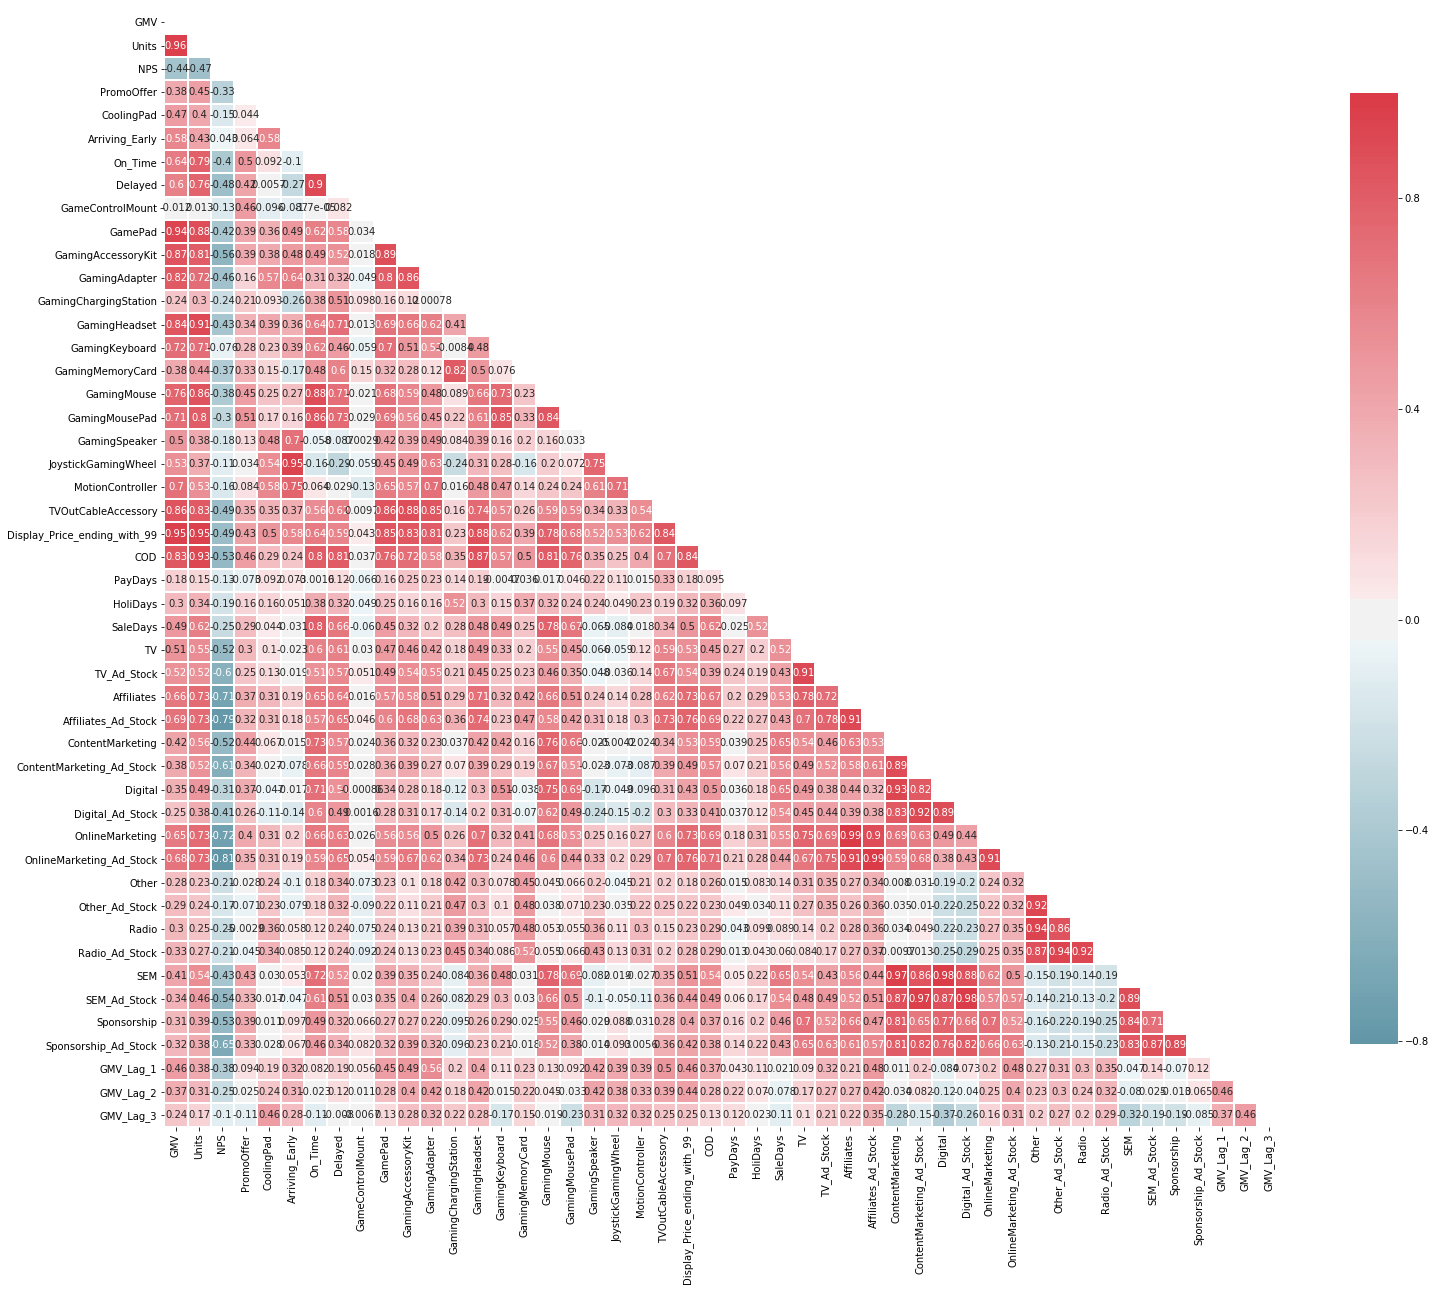

In [340]:
# Corelation matrix
corr=CA_Lag.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,annot = True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.9, cbar_kws={"shrink": .7})
#plt.figure(figsize = (16, 10))
#sns.heatmap(df_CA_Lag.corr(), annot = True, cmap="YlGnBu")
#plt.show()

In [351]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_test = train_test_split(CA_Lag, train_size = 0.7, test_size = 0.3, random_state = 100)

In [352]:
# Creating Predicter and influencer variable for Lenier Model 
y_train = df_train.pop('GMV')
X_train = df_train

In [353]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)
# variables with ranking
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Units', True, 1),
 ('NPS', False, 9),
 ('PromoOffer', False, 25),
 ('CoolingPad', False, 10),
 ('Arriving_Early', True, 1),
 ('On_Time', True, 1),
 ('Delayed', False, 22),
 ('GameControlMount', False, 8),
 ('GamePad', False, 17),
 ('GamingAccessoryKit', True, 1),
 ('GamingAdapter', False, 24),
 ('GamingChargingStation', False, 18),
 ('GamingHeadset', True, 1),
 ('GamingKeyboard', False, 11),
 ('GamingMemoryCard', False, 27),
 ('GamingMouse', False, 3),
 ('GamingMousePad', False, 29),
 ('GamingSpeaker', False, 15),
 ('JoystickGamingWheel', False, 12),
 ('MotionController', False, 2),
 ('TVOutCableAccessory', False, 7),
 ('Display_Price_ending_with_99', False, 16),
 ('COD', True, 1),
 ('PayDays', False, 6),
 ('HoliDays', False, 13),
 ('SaleDays', False, 20),
 ('TV', False, 19),
 ('TV_Ad_Stock', True, 1),
 ('Affiliates', False, 26),
 ('Affiliates_Ad_Stock', True, 1),
 ('ContentMarketing', False, 5),
 ('ContentMarketing_Ad_Stock', False, 31),
 ('Digital', True, 1),
 ('Digital_Ad_Stock',

In [354]:
#Building Linear Regression Model with Lag Variable which gives Distributive Lag Model
#Iteration 1 - CA DL Model
col = X_train.columns[rfe.support_]
import statsmodels.api as sm

X_train_lm = X_train[col]
X_train_lm = sm.add_constant(X_train_lm)
dl = sm.OLS(y_train,X_train_lm).fit()
print(dl.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     201.9
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.07e-17
Time:                        12:13:44   Log-Likelihood:                 41.847
No. Observations:                  35   AIC:                            -51.69
Df Residuals:                      19   BIC:                            -26.81
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1568    

In [356]:
X_train_lm = X_train_lm.drop(['Digital'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl2 = sm.OLS(y_train,X_train_lm).fit() 
print(dl2.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     223.9
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           8.12e-19
Time:                        12:13:47   Log-Likelihood:                 41.556
No. Observations:                  35   AIC:                            -53.11
Df Residuals:                      20   BIC:                            -29.78
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1410    

In [357]:
X_train_lm = X_train_lm.drop(['Arriving_Early'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl3 = sm.OLS(y_train,X_train_lm).fit() 
print(dl3.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     241.6
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           8.05e-20
Time:                        12:13:48   Log-Likelihood:                 40.741
No. Observations:                  35   AIC:                            -53.48
Df Residuals:                      21   BIC:                            -31.71
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0806    

In [358]:
X_train_lm = X_train_lm.drop(['GMV_Lag_3'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl4 = sm.OLS(y_train,X_train_lm).fit() 
print(dl4.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     247.1
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.46e-20
Time:                        12:13:50   Log-Likelihood:                 38.933
No. Observations:                  35   AIC:                            -51.87
Df Residuals:                      22   BIC:                            -31.65
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0524    

In [359]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,SEM_Ad_Stock,556.22
8,Digital_Ad_Stock,476.45
7,Affiliates_Ad_Stock,93.21
12,Sponsorship,67.50
6,TV_Ad_Stock,63.50
10,SEM,59.47
5,COD,44.63
1,Units,31.00
4,GamingHeadset,26.78
2,On_Time,15.52


In [360]:
X_train_lm = X_train_lm.drop(['SEM_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl5 = sm.OLS(y_train,X_train_lm).fit() 
print(dl5.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     209.5
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.44e-20
Time:                        12:16:58   Log-Likelihood:                 33.792
No. Observations:                  35   AIC:                            -43.58
Df Residuals:                      23   BIC:                            -24.92
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0258    

In [361]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,SEM,57.05
5,COD,37.25
11,Sponsorship,34.52
1,Units,30.27
6,TV_Ad_Stock,17.94
4,GamingHeadset,17.84
2,On_Time,15.48
8,Digital_Ad_Stock,13.35
7,Affiliates_Ad_Stock,10.48
3,GamingAccessoryKit,7.79


In [362]:
X_train_lm = X_train_lm.drop(['Affiliates_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl6 = sm.OLS(y_train,X_train_lm).fit() 
print(dl6.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     236.1
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           1.89e-21
Time:                        12:17:51   Log-Likelihood:                 33.473
No. Observations:                  35   AIC:                            -44.95
Df Residuals:                      24   BIC:                            -27.84
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0305      0

In [363]:
X_train_lm = X_train_lm.drop(['GamingAccessoryKit'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl7 = sm.OLS(y_train,X_train_lm).fit() 
print(dl7.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     250.7
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           3.18e-22
Time:                        12:18:28   Log-Likelihood:                 31.981
No. Observations:                  35   AIC:                            -43.96
Df Residuals:                      25   BIC:                            -28.41
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0281      0.024  

In [364]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
8,SEM,45.83
9,Sponsorship,25.27
1,Units,23.01
4,COD,19.72
6,Digital_Ad_Stock,12.63
2,On_Time,8.39
3,GamingHeadset,8.17
5,TV_Ad_Stock,7.00
7,Other,2.49
0,const,1.48


In [365]:
X_train_lm = X_train_lm.drop(['TV_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl7 = sm.OLS(y_train,X_train_lm).fit() 
print(dl7.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     262.1
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           7.55e-23
Time:                        12:19:27   Log-Likelihood:                 30.033
No. Observations:                  35   AIC:                            -42.07
Df Residuals:                      26   BIC:                            -28.07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0132      0.023  

In [366]:
X_train_lm = X_train_lm.drop(['Digital_Ad_Stock'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl8 = sm.OLS(y_train,X_train_lm).fit() 
print(dl8.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     295.3
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           8.17e-24
Time:                        12:20:03   Log-Likelihood:                 29.135
No. Observations:                  35   AIC:                            -42.27
Df Residuals:                      27   BIC:                            -29.83
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0171      0.023      0.755

In [367]:
X_train_lm = X_train_lm.drop(['COD'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl9 = sm.OLS(y_train,X_train_lm).fit() 
print(dl9.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     337.0
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           9.21e-25
Time:                        12:20:40   Log-Likelihood:                 28.124
No. Observations:                  35   AIC:                            -42.25
Df Residuals:                      28   BIC:                            -31.36
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0164      0.023      0.716

In [368]:
# VIF 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,Units,13.94
5,SEM,10.72
6,Sponsorship,9.20
3,GamingHeadset,6.46
2,On_Time,6.25
4,Other,1.30
0,const,1.25


In [389]:
X_train_lm = X_train_lm.drop(['Sponsorship'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl10 = sm.OLS(y_train,X_train_lm).fit() 
print(dl10.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     356.2
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           4.27e-25
Time:                        12:28:43   Log-Likelihood:                 25.335
No. Observations:                  35   AIC:                            -38.67
Df Residuals:                      29   BIC:                            -29.34
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0039      0.022     -0.174

In [395]:
X_train_lm = X_train_lm.drop(['Other'], axis = 1)

X_train_lm = sm.add_constant(X_train_lm)
dl11 = sm.OLS(y_train,X_train_lm).fit() 
print(dl11.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     306.2
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           7.44e-24
Time:                        12:30:10   Log-Likelihood:                 18.331
No. Observations:                  35   AIC:                            -26.66
Df Residuals:                      30   BIC:                            -18.88
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0055      0.027     -0.204

Text(0.5,0,'Errors')

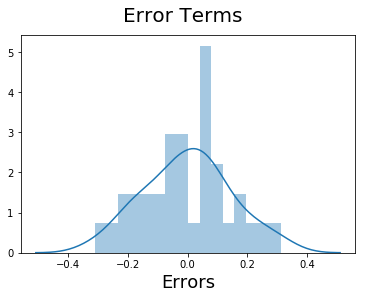

In [396]:
# Testing Error Rate
y_train_GMV = dl11.predict(X_train_lm)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_GMV), bins = 16)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

In [370]:
y_test=df_test.pop('GMV')
X_test=df_test

In [397]:
# Now let's use our model to make predictions.
# Creating X_test_new dataframe 

X_test_new=X_test[['Units','SEM','GamingHeadset','On_Time']]

X_test_new = sm.add_constant(X_test_new)
y_pred = dl11.predict(X_test_new)
y_pred

Week
40   -1.668791
70    1.904045
71    0.261032
62    0.549345
77    0.344743
38   -2.055447
37   -2.308822
67    0.241034
54    0.498363
76    0.512791
27   -1.953515
45    0.810856
52    0.998730
79   -0.859885
72    0.590520
dtype: float64

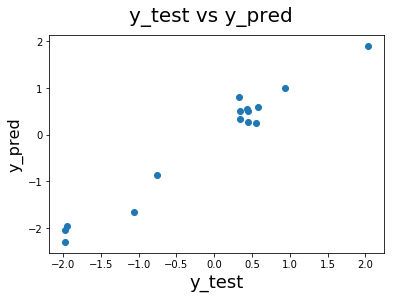

In [398]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

plt.show()

In [399]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9529653031635656